# what are the spatial patterns of overall crime rates and the rates of the three crime categories  in London?

# Introduction

This notebook aimes to find spatial patterns of crime in London. Including 3 typess of crimes. I use a serious ways to validate what I found in clustering analysis.

# Literature Review

In both academic and practical settings, the most popular methods for detecting crime hot spots are based on spatial autocorrelation and kernel density analysis(Murray and Grubesic, 2013). In contrast, non-hierarchical clustering techniques like k-means are less frequently utilized in various scenarios(Murray and Grubesic, 2013). However, Alkhaibari and Chung(2017) employed clustering algorithms like K-Means and agglomerative clustering on the 2015 NYPD Stop, Question and Frisk Report Database to analyze crime locations and stop reasons, aiming to reduce urban crime rates. By applying internal validation methods to compare K-Means and agglomerative clustering, it was determined that the K-Means algorithm performed the best among all tested clustering algorithms(Alkhaibari and Chung2017). This contradiction inspired me to use the K-Means algorithm to detect clusters of crime in London and their spatial distribution, while also attempting to extract useful insights from the cluster distributions obtained through analysis.

In addition, In criminology, a widely acknowledged aspect is the consistent age pattern observed in criminal activities, which has remained invariant across various social conditions(Hirschi and Gottfredson, 1983). Steffensmeier et al(1989) utilized arrest data from the FBI's Uniform Crime Reports analyzing parameters including the peak age of criminality, the overall shape of the age-crime curve, and the rate of decline from the peak age and their findings indicate that although crime rates generally decline throughout life after initially rising during adolescence, some types of crimes may peak later in life, decline more slowly, or both. 
Therefore, I believe it is meaningful to include the proportion of adolescents in each LSOA (Lower Layer Super Output Area) when conducting cluster analysis on crime rates in London. This also suggests that different types of crimes may exhibit distinct characteristics, hence I will perform separate cluster analyses for different types of crimes.


According to the economic theory of crime, an increase in unemployment rates leads to a rise in property crime rates. One finding indicates that unemployment has a significant positive impact on property crime rates, and this result is consistent across different model specifications but the evidence for violent crime is relatively weak(Raphael and Winter-Ebmer, 2001). Another study shows that unemployment significantly positively affects certain types of property crimes, such as burglary, car theft, and bicycle theft(Edmark, 2005). 
Therefore, I plan to incorporate unemployment rates into my study to examine whether clusters with high crime rates also have correspondingly high unemployment rates. This will help further understand the relationship between crime rates and economic conditions.

Based on the previous research applied to the context of London crime data, I plan to categorize all types of crimes into three main categories: Public Order, Violent, and Property.
(Xu, Pennington-Gray and Kim, 2019;Flatley, 2017)









 





# Research Question

Therefore, based on the discussion above, my research question is: Considering unemployment rates and the proportion of adolescents, what are the spatial patterns of overall crime rates and the rates of the three crime categories (Public Order, Violent, Property) in London? How can we interpret the formation of these clusters, and what insights can be gained from them?

# Methodology
The mean that I will use to detect clustering is K-Means. 
K-means and its variants are commonly used for unsupervised clustering in pattern recognition and machine learning. However, K-means does not fully conform to the standards of unsupervised clustering methods because its effectiveness largely depends on the choice of initial cluster centers and the predetermined number of clusters(K. P. Sinaga and M. -S. Yang, 2020).
- How K-Means Works:
1. Initialization:
Start by selecting 
K initial points as the centroids of the clusters. These points can be chosen randomly from the dataset .
1. Assignment:
Assign each data point to the nearest cluster by calculating the distance from each data point to each centroid. The most common distance metric used is Euclidean distance.
1. Update:
Once all points have been assigned to clusters, recalculate the centroids of these clusters. The new centroid is typically the mean of all points assigned to that cluster.
1. Iteration:
Repeat the assignment and update steps until the centroids no longer change significantly, indicating that the clusters have stabilized, or a predetermined number of iterations is reached.
- Advantages of K-Means:
1. Efficiency: K-means is computationally efficient, making it suitable for large datasets, although its computational cost grows as the number of clusters increases(Govender and Sivakumar, 2020).
2. Simplicity: The algorithm is straightforward to implement and understand, which makes it a good baseline method for clustering tasks.
3. Scalability: It scales well to large numbers of samples and has been implemented in various platforms that support big data technologies.
- Disadvantages of K-Means:
1. Sensitivity to Initial Centroids: The initial selection of centroids can affect the final clusters. Poor initial centroids can result in sub-optimal clustering, which can be mitigated by multiple runs of the algorithm with different initializations.
2. Fixed Number of Clusters: The algorithm requires the number of clusters to be specified beforehand, which is not always practical when prior knowledge of the data is limited(Ahmed, Seraj and Islam, 2020).
3. Incapable of handling clusters of a non-convex shape: 
For non-convex functions, the situation with local minima and global minima is more complex. K-means tends to fall into the trap of local minima, overlooking the global minimum.
4. Sensitive to outliers, which can result in inaccurate clusters

# Data loading and Exploration



These are the packages will be used.

In [83]:
import os
from requests import get
from urllib.parse import urlparse
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import plotly.express as px
import matplotlib.image as mpimg
from math import ceil
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from esda.adbscan import ADBSCAN

from scipy.cluster.hierarchy import dendrogram

import spopt
from spopt.region import MaxPHeuristic as MaxP


import libpysal
import warnings

Now let us load and explain the datasets.


In [71]:


def cache_data(src: str, dest: str) -> str:
    """
    Downloads a file from the specified URL to a destination directory if not already present.
    
    Parameters:
        src (str): The source URL from which the file will be downloaded.
        dest (str): The destination directory where the file will be stored.
    
    Returns:
        str: The path to the downloaded or existing file.
    
    This function checks if the file exists in the specified destination directory.
    If it does not exist, the function downloads the file. If the directory does not exist,
    it creates the directory (and any required parent directories).
    """
    
    # Parse the URL to extract the file name
    url = urlparse(src) 
    fn = os.path.split(url.path)[-1]  # Extract the filename from the URL path
    
    # Combine the destination directory and filename to form the full path
    dfn = os.path.join(dest, fn) 
    
    # Check if the file already exists at the destination
    if not os.path.isfile(dfn):
        print(f"{dfn} not found, downloading!")
        
        # Ensure the destination directory exists, create if it doesn't
        if not os.path.exists(dest):
            os.makedirs(dest, exist_ok=True)
        
        # Download the file and write to the destination filename
        with open(dfn, "wb") as file:
            response = get(src)  # Download the file
            file.write(response.content)  # Write the content to file
            
        print("\tDone downloading...")
    else:
        print(f"Found {dfn} locally!")

    return dfn  # Return the path to the file

In [3]:
ddir  = os.path.join('data') # destination directory
spath = 'https://www.dropbox.com/scl/fi/' # source path for dropbox

This CSV file contains the attributes of each Lower Layer Super Output Area (LSOA) in England and Wales. It is based on the data from Census 2021 carried by Office for National Statistics, by the mean that aski people questions(Home - Office for National Statistics, no date). This is not raw data, as due to some limitations, only a portion of the data can be downloaded at a time. Therefore, I have downloaded the data multiple times in advance and then merged them to create this more complete file of LSOA attributes.

In [72]:

lsoa_stat = pd.read_csv(cache_data(spath + 'qqo8gajxuo7ceentfw1wz/lsoa_full.csv?rlkey=0h4ye1f5b6eg9yw8ne0s4xcjn&dl=1', ddir), low_memory=False)

Found data\lsoa_full.csv locally!


In [69]:
lsoa_stat

LSOA code local authority code local authority name  All households   \
0     E01000001            E09000001       City of London              838   
1     E01000002            E09000001       City of London              824   
2     E01000003            E09000001       City of London             1018   
3     E01000005            E09000001       City of London              478   
4     E01032739            E09000001       City of London              882   
...         ...                  ...                  ...              ...   
4989  E01035718            E09000033          Westminster              732   
4990  E01035719            E09000033          Westminster              634   
4991  E01035720            E09000033          Westminster              587   
4992  E01035721            E09000033          Westminster             1302   
4993  E01035722            E09000033          Westminster             1178   

      Detached  Semi-detached  Terraced  Purpose built flat  \
0            0              3        14                 803   
1            1              2        29                 768   
2            1              0         0                 996   
3            0              0         2                 456   
4            2              7        17                 608   
...        ...            ...       ...                 ...   
4989        11             30       173                 358   
4990         0              1         1                 624   
4991         2              2        45                 483   
4992         4             22       138                1079   
4993         6              2        29                 858   

      Flat in a converted/ shared house (includes all households in shared dwellings)  \
0                                                    10                                 
1                                                    16                                 
2                                                    15                                 
3                                                    10                                 
4                                                   152                                 
...                                                 ...                                 
4989                                                148                                 
4990                                                  8                                 
4991                                                 48                                 
4992                                                 35                                 
4993                                                277                                 

      Flat in a commercial building  ...  Private landlord or letting agency  \
0                                 8  ...                                 283   
1                                 8  ...                                 324   
2                                 6  ...                                 293   
3                                10  ...                                  91   
4                                96  ...                                 555   
...                             ...  ...                                 ...   
4989                             11  ...                                 276   
4990                              0  ...                                 226   
4991                              7  ...                                 155   
4992                             23  ...                                 354   
4993                              6  ...                                 769   

      Other private rented  Rent free  All Usual residents aged 5+  \
0                       53          1                         1423   
1                       38          0                         1350   
2                       42          2                         1574   
3 

These CSV files provide street-level crime, outcome, and stop and search information, broken down by police force and 2021 lower layer super output area (LSOA)(About | data.police.uk, no date).


- Columns in the CSV files
1. Reported by:	The force that provided the data about the crime.
2. Falls within:	At present, also the force that provided the data about the crime. This is currently being looked into and is likely to change in the near future.
3. Longitude and Latitude:	The anonymised coordinates of the crime. 
4. LSOA code and LSOA name:	References to the Lower Layer Super Output Area that the anonymised point falls into, according to the LSOA boundaries provided by the Office for National Statistics.
5. Crime type:	One of the crime types listed in the Police.UK FAQ.
6. Last outcome category:	A reference to whichever of the outcomes associated with the crime occurred most recently. For example, this crime's 'Last outcome category' would be 'Formal action is not in the public interest'.
7. Context:	A field provided for forces to provide additional human-readable data about individual crimes. Currently, for newly added CSVs, this is always empty.

In [5]:
crime = pd.read_csv(cache_data(spath + '5ckyvra71cdmzjqb2jvs4/2023london_crime.csv?rlkey=4p4i3twb9erb5jpopqek3gyty&dl=1', ddir), low_memory=False)

Found data\2023london_crime.csv locally!


In [70]:
crime

Crime ID  \
0        8536e93fb3ce916daa4251bd53c1a4416ba4159a938340...   
1        483d52d514591a895c829dece6091c31f797b7dcfd0735...   
2        63343c1f1236bad8ce08d130f37760172dc33b20af2b56...   
3        a3d980f554d3ece9e8dcda8518ae87bfa9c75d62396105...   
4        bfb1d1da32341b7129e789130001d96f7e603088593dc5...   
...                                                    ...   
1048476  6ea18f57499bbe2b7d241605c9f7b7233378799f4ef2df...   
1048477  93f09bc79a85358faa143cf835f86b9f6fbcf08b6976bf...   
1048478  37022111f232b614c500c223664310f45148fb7393e06f...   
1048479  8fd906ccd41a2c7d0f87a695c10fd58118005620e56860...   
1048480  fd8da55614c44df3762dbbdd98d2d79d3117741bcb17ef...   

                         Reported by                 Falls within  Longitude  \
0        Metropolitan Police Service  Metropolitan Police Service  -0.681541   
1        Metropolitan Police Service  Metropolitan Police Service  -0.684107   
2        Metropolitan Police Service  Metropolitan Police Service  -0.928552   
3        Metropolitan Police Service  Metropolitan Police Service  -0.772051   
4        Metropolitan Police Service  Metropolitan Police Service  -0.804965   
...                              ...                          ...        ...   
1048476        City of London Police        City of London Police        NaN   
1048477        City of London Police        City of London Police        NaN   
1048478        City of London Police        City of London Police        NaN   
1048479        City of London Police        City of London Police        NaN   
1048480        City of London Police        City of London Police        NaN   

          Latitude                        Location  LSOA code  \
0        50.792113         On or near Fletcher Way  E01031444   
1        50.780541  On or near Victoria Road South  E01031437   
2        51.923331       On or near St Marys Close  E01017714   
3        51.827897      On or near Restharrow Road  E01017641   
4        51.811332         On or near Walton Grove  E01017637   
...            ...                             ...        ...   
1048476        NaN                     No Location        NaN   
1048477        NaN                     No Location        NaN   
1048478        NaN                     No Location        NaN   
1048479        NaN                     No Location        NaN   
1048480        NaN                     No Location        NaN   

                   LSOA name                    Crime type  \
0                  Arun 016B  Violence and sexual offences   
1                  Arun 017E                   Other theft   
2        Aylesbury Vale 004D  Violence and sexual offences   
3        Aylesbury Vale 007A  Violence and sexual offences   
4        Aylesbury Vale 017C  Violence and sexual offences   
...                      ...                           ...   
1048476                  NaN                   Other crime   
1048477                  NaN                   Other crime   
1048478                  NaN                   Other crime   
1048479                  NaN                   Other crime   
1048480                  NaN                   Other crime   

                                 Last outcome category  Context  
0                            Status update unavailable      NaN  
1        Investigation complete; no suspect identified      NaN  
2                            Status update unavailable      NaN  
3        Investigation complete; no suspect identified      NaN  
4                            Status update unavailable      NaN  
...                                                ...      ...  
1048476                      Status update unavailable      NaN  
1048477                      Status update unavailable      NaN  
1048478                      Status update unavailable      NaN  
1048479                      Status update unavailable      NaN  
1048480                      Status update unavailable      NaN  

[1048481 rows x 11 column

It is a GeoPackage containing detailed geospatial data about Lower Layer Super Output Areas (LSOAs) in London.

In [6]:
lsoa = gpd.read_file(cache_data(spath+'6yc108b81708sgyetr3kt/lsoa_london.gpkg?rlkey=sdzd1miqd623lpn1akj6gelj0&dl=1', ddir))

Found data\lsoa_london.gpkg locally!



Convert the crime data with coordinates into a GeoDataFrame to prepare for analyzing the number of crimes in each Lower Layer Super Output Area (LSOA) in London.

In [8]:
gdf_crime = gpd.GeoDataFrame(crime, 
      geometry=gpd.points_from_xy(crime.Longitude, crime.Latitude, crs='epsg:4326'))

This describes how I categorized all types of crimes into three major categories.

Public order: public order, drugs, possession of weapons, anti-social behavior.

Violent(involve force): robbery, violence and sexual offenses. 

Property(without force): burglary, criminal damage and arson, shoplifting, theft, vehicle crime.


In [9]:
crime_public_order = ['Public order', 'Drugs', 'Anti-social behaviour','Possession of weapons']
crime_violent = ['Robbery', 'Violence and sexual offences'] 
crime_property = ['Burglary','Theft from the person', 'Bicycle theft' 'Criminal damage and arson', 'Shoplifting','Vehicle crime','Other theft']



In [10]:
gdf_crime = gdf_crime[~gdf_crime['Crime type'].isin(['Other crime'])]

In [11]:
gdf_crime['crime_category'] = np.select(
    [gdf_crime['Crime type'].isin(crime_public_order),
     gdf_crime['Crime type'].isin(crime_violent),
     gdf_crime['Crime type'].isin(crime_property)],
    ['public order', 'violent', 'property'],
    default='other'
)

In [12]:
gdf_crime.head()

Crime ID  \
0  8536e93fb3ce916daa4251bd53c1a4416ba4159a938340...   
1  483d52d514591a895c829dece6091c31f797b7dcfd0735...   
2  63343c1f1236bad8ce08d130f37760172dc33b20af2b56...   
3  a3d980f554d3ece9e8dcda8518ae87bfa9c75d62396105...   
4  bfb1d1da32341b7129e789130001d96f7e603088593dc5...   

                   Reported by                 Falls within  Longitude  \
0  Metropolitan Police Service  Metropolitan Police Service  -0.681541   
1  Metropolitan Police Service  Metropolitan Police Service  -0.684107   
2  Metropolitan Police Service  Metropolitan Police Service  -0.928552   
3  Metropolitan Police Service  Metropolitan Police Service  -0.772051   
4  Metropolitan Police Service  Metropolitan Police Service  -0.804965   

    Latitude                        Location  LSOA code            LSOA name  \
0  50.792113         On or near Fletcher Way  E01031444            Arun 016B   
1  50.780541  On or near Victoria Road South  E01031437            Arun 017E   
2  51.923331       On or near St Marys Close  E01017714  Aylesbury Vale 004D   
3  51.827897      On or near Restharrow Road  E01017641  Aylesbury Vale 007A   
4  51.811332         On or near Walton Grove  E01017637  Aylesbury Vale 017C   

                     Crime type  \
0  Violence and sexual offences   
1                   Other theft   
2  Violence and sexual offences   
3  Violence and sexual offences   
4  Violence and sexual offences   

                           Last outcome category  Context  \
0                      Status update unavailable      NaN   
1  Investigation complete; no suspect identified      NaN   
2                      Status update unavailable      NaN   
3  Investigation complete; no suspect identified      NaN   
4                      Status update unavailable      NaN   

                    geometry crime_category  
0  POINT (-0.68154 50.79211)        violent  
1  POINT (-0.68411 50.78054)       property  
2  POINT (-0.92855 51.92333)        violent  
3  POINT (-0.77205 51.82790)        violent  
4  POINT (-0.80497 51.81133)        violent

In [13]:
print(f"Data frame is {gdf_crime.shape[0]:,} x {gdf_crime.shape[1]}")

Data frame is 1,038,304 x 13


In [14]:
gdf_crime = gdf_crime.to_crs('epsg:27700')


In [15]:
gdf_crime_pu = gdf_crime[gdf_crime['crime_category']=='public order']
gdf_crime_vi = gdf_crime[gdf_crime['crime_category']=='violent']
gdf_crime_pr = gdf_crime[gdf_crime['crime_category']=='property']

Assign each crime to the corresponding Lower Layer Super Output Area (LSOA) based on its location and calculate the total number of crimes as well as the count for each of the three major crime categories.

In [16]:
lsoa_merge = lsoa

# Spatial crime listings and lsoa, summarise by count
sjoin_lsoa = gpd.sjoin(gdf_crime, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['crime_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa

In [17]:
sjoin_lsoa = gpd.sjoin(gdf_crime_pu, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['public_order_crime_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa

In [18]:
sjoin_lsoa = gpd.sjoin(gdf_crime_vi, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['violent_crime_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa

In [19]:
sjoin_lsoa = gpd.sjoin(gdf_crime_pr, lsoa_merge)
count_dict = sjoin_lsoa['LSOA21CD'].value_counts().to_dict() # count the values with value counts
lsoa_merge['property_crime_count'] = lsoa_merge['LSOA21CD'].map(count_dict) # map it back to lsoa

In [20]:
lsoa_merge

OBJECTID   LSOA21CD                   LSOA21NM  \
0            1  E01000001        City of London 001A   
1            2  E01000002        City of London 001B   
2            3  E01000003        City of London 001C   
3            4  E01000005        City of London 001E   
4            5  E01000006  Barking and Dagenham 016A   
...        ...        ...                        ...   
4989     33712  E01035718           Westminster 019G   
4990     33713  E01035719           Westminster 021F   
4991     33714  E01035720           Westminster 021G   
4992     33715  E01035721           Westminster 023H   
4993     33716  E01035722           Westminster 024G   

                                  GlobalID  \
0     f1865556-4e62-48e3-a025-d93a40f15e46   
1     83e78aad-ee05-44a5-a8d3-077de6ed4053   
2     69c457df-229e-4446-9577-95ac1c9be694   
3     d537d59f-237a-45ed-a514-b0ab2a93e510   
4     8d0081fe-69e2-48ac-aaf9-fd270d60e339   
...                                    ...   
4989  8ce44e30-7ce1-4ce5-b99c-22fd920bafc8   
4990  4a204f9d-15c0-4043-848d-14bc504402e3   
4991  9282c1d4-8e39-49a8-86a7-f85e97211fe5   
4992  20805ec5-7f21-4ecb-b469-ecf528636354   
4993  e5eec9e8-84b6-46aa-9764-dd651919e998   

                                               geometry  crime_count  \
0     POLYGON ((532105.312 182010.574, 532162.491 18...        150.0   
1     POLYGON ((532634.497 181926.016, 532619.141 18...        382.0   
2     POLYGON ((532135.138 182198.131, 532158.250 18...         97.0   
3     POLYGON ((533808.018 180767.774, 533649.037 18...        712.0   
4     POLYGON ((545122.049 184314.931, 545271.849 18...         91.0   
...                                                 ...          ...   
4989  POLYGON ((528427.719 180115.109, 528410.126 17...       1811.0   
4990  POLYGON ((530276.465 178962.701, 530238.780 17...         88.0   
4991  POLYGON ((529867.785 178609.306, 529892.537 17...        156.0   
4992  POLYGON ((528674.775 178693.078, 528612.868 17...        875.0   
4993  POLYGON ((529651.808 178210.675, 529692.695 17...        164.0   

      public_order_crime_count  violent_crime_count  property_crime_count  
0                         34.0                 18.0                  75.0  
1                         50.0                 56.0                 240.0  
2                         22.0                 25.0                  35.0  
3                        146.0                158.0                 366.0  
4                         28.0                 39.0                  18.0  
...                        ...                  ...                   ...  
4989                     325.0                300.0                1082.0  
4990                      38.0                 19.0                  22.0  
4991                      79.0                 36.0                  28.0  
4992                     265.0                127.0                 447.0  
4993                      62.0                 46.0                  43.0  

[4994 rows x 9 columns]

Calculate the variables I need and merge them by LSOA code

When calculating the unemployment rate, we use the number of people aged 16 and older as the denominator(Home - Office for National Statistics, no date).

In [21]:
lsoa_stat['unemployed_rate'] = (lsoa_stat['Economically active: Unemployed'])/lsoa_stat['All usual residents aged 16 or over']
lsoa_stat['teenage_rate'] = (lsoa_stat['Aged 16 to 17'] + lsoa_stat['Aged 15 '])/lsoa_stat['All usual residents']
lsoa_stat_selected = lsoa_stat[['LSOA code','local authority code','All usual residents','unemployed_rate','teenage_rate']]

In [22]:
# Merge selected columns from lsoa_stat to lsoa_merge by LSOA21CD
lsoa_merge1 = lsoa_merge.merge(lsoa_stat_selected, left_on = 'LSOA21CD',right_on='LSOA code', how='left').drop(columns=['LSOA code'])

# Add density for each column in lsoa_merge using 'All usual residents' in lsoa_stat
lsoa_merge1['crime_rate'] = lsoa_merge1['crime_count']/lsoa_merge1['All usual residents']
lsoa_merge1['public_order_crime_rate'] = lsoa_merge1['public_order_crime_count']/lsoa_merge1['All usual residents']
lsoa_merge1['violent_crime_rate'] = lsoa_merge1['violent_crime_count']/lsoa_merge1['All usual residents']
lsoa_merge1['property_crime_rate'] = lsoa_merge1['property_crime_count']/lsoa_merge1['All usual residents']

In [73]:
lsoa_merge1

OBJECTID   LSOA21CD                   LSOA21NM  \
0            1  E01000001        City of London 001A   
1            2  E01000002        City of London 001B   
2            3  E01000003        City of London 001C   
3            4  E01000005        City of London 001E   
4            5  E01000006  Barking and Dagenham 016A   
...        ...        ...                        ...   
4989     33712  E01035718           Westminster 019G   
4990     33713  E01035719           Westminster 021F   
4991     33714  E01035720           Westminster 021G   
4992     33715  E01035721           Westminster 023H   
4993     33716  E01035722           Westminster 024G   

                                  GlobalID  \
0     f1865556-4e62-48e3-a025-d93a40f15e46   
1     83e78aad-ee05-44a5-a8d3-077de6ed4053   
2     69c457df-229e-4446-9577-95ac1c9be694   
3     d537d59f-237a-45ed-a514-b0ab2a93e510   
4     8d0081fe-69e2-48ac-aaf9-fd270d60e339   
...                                    ...   
4989  8ce44e30-7ce1-4ce5-b99c-22fd920bafc8   
4990  4a204f9d-15c0-4043-848d-14bc504402e3   
4991  9282c1d4-8e39-49a8-86a7-f85e97211fe5   
4992  20805ec5-7f21-4ecb-b469-ecf528636354   
4993  e5eec9e8-84b6-46aa-9764-dd651919e998   

                                               geometry  crime_count  \
0     POLYGON ((532105.312 182010.574, 532162.491 18...        150.0   
1     POLYGON ((532634.497 181926.016, 532619.141 18...        382.0   
2     POLYGON ((532135.138 182198.131, 532158.250 18...         97.0   
3     POLYGON ((533808.018 180767.774, 533649.037 18...        712.0   
4     POLYGON ((545122.049 184314.931, 545271.849 18...         91.0   
...                                                 ...          ...   
4989  POLYGON ((528427.719 180115.109, 528410.126 17...       1811.0   
4990  POLYGON ((530276.465 178962.701, 530238.780 17...         88.0   
4991  POLYGON ((529867.785 178609.306, 529892.537 17...        156.0   
4992  POLYGON ((528674.775 178693.078, 528612.868 17...        875.0   
4993  POLYGON ((529651.808 178210.675, 529692.695 17...        164.0   

      public_order_crime_count  violent_crime_count  property_crime_count  \
0                         34.0                 18.0                  75.0   
1                         50.0                 56.0                 240.0   
2                         22.0                 25.0                  35.0   
3                        146.0                158.0                 366.0   
4                         28.0                 39.0                  18.0   
...                        ...                  ...                   ...   
4989                     325.0                300.0                1082.0   
4990                      38.0                 19.0                  22.0   
4991                      79.0                 36.0                  28.0   
4992                     265.0                127.0                 447.0   
4993                      62.0                 46.0                  43.0   

     local authority code  ...  teenage_rate  crime_rate  \
0               E09000001  ...      0.014257    0.101833   
1               E09000001  ...      0.023878    0.276411   
2               E09000001  ...      0.022319    0.060136   
3               E09000001  ...      0.041404    0.640864   
4               E09000002  ...      0.025543    0.049457   
...                   ...  ...           ...         ...   
4989            E09000033  ...      0.089001    0.703848   
4990            E09000033  ...      0.043171    0.069074   
4991            E09000033  ...      0.031199    0.128079   
4992            E09000033  ...      0.025784    0.376021   
4993            E09000033  ...      0.020357    0.081430   

      public_order_crime_rate  violent_crime_rate  property_crime_rate  \
0                    0.023082            0.012220             0.050916   
1                    0.036179            0.040521             0.173661   
2                    0.013639            0.0154

Look at the distribution of data

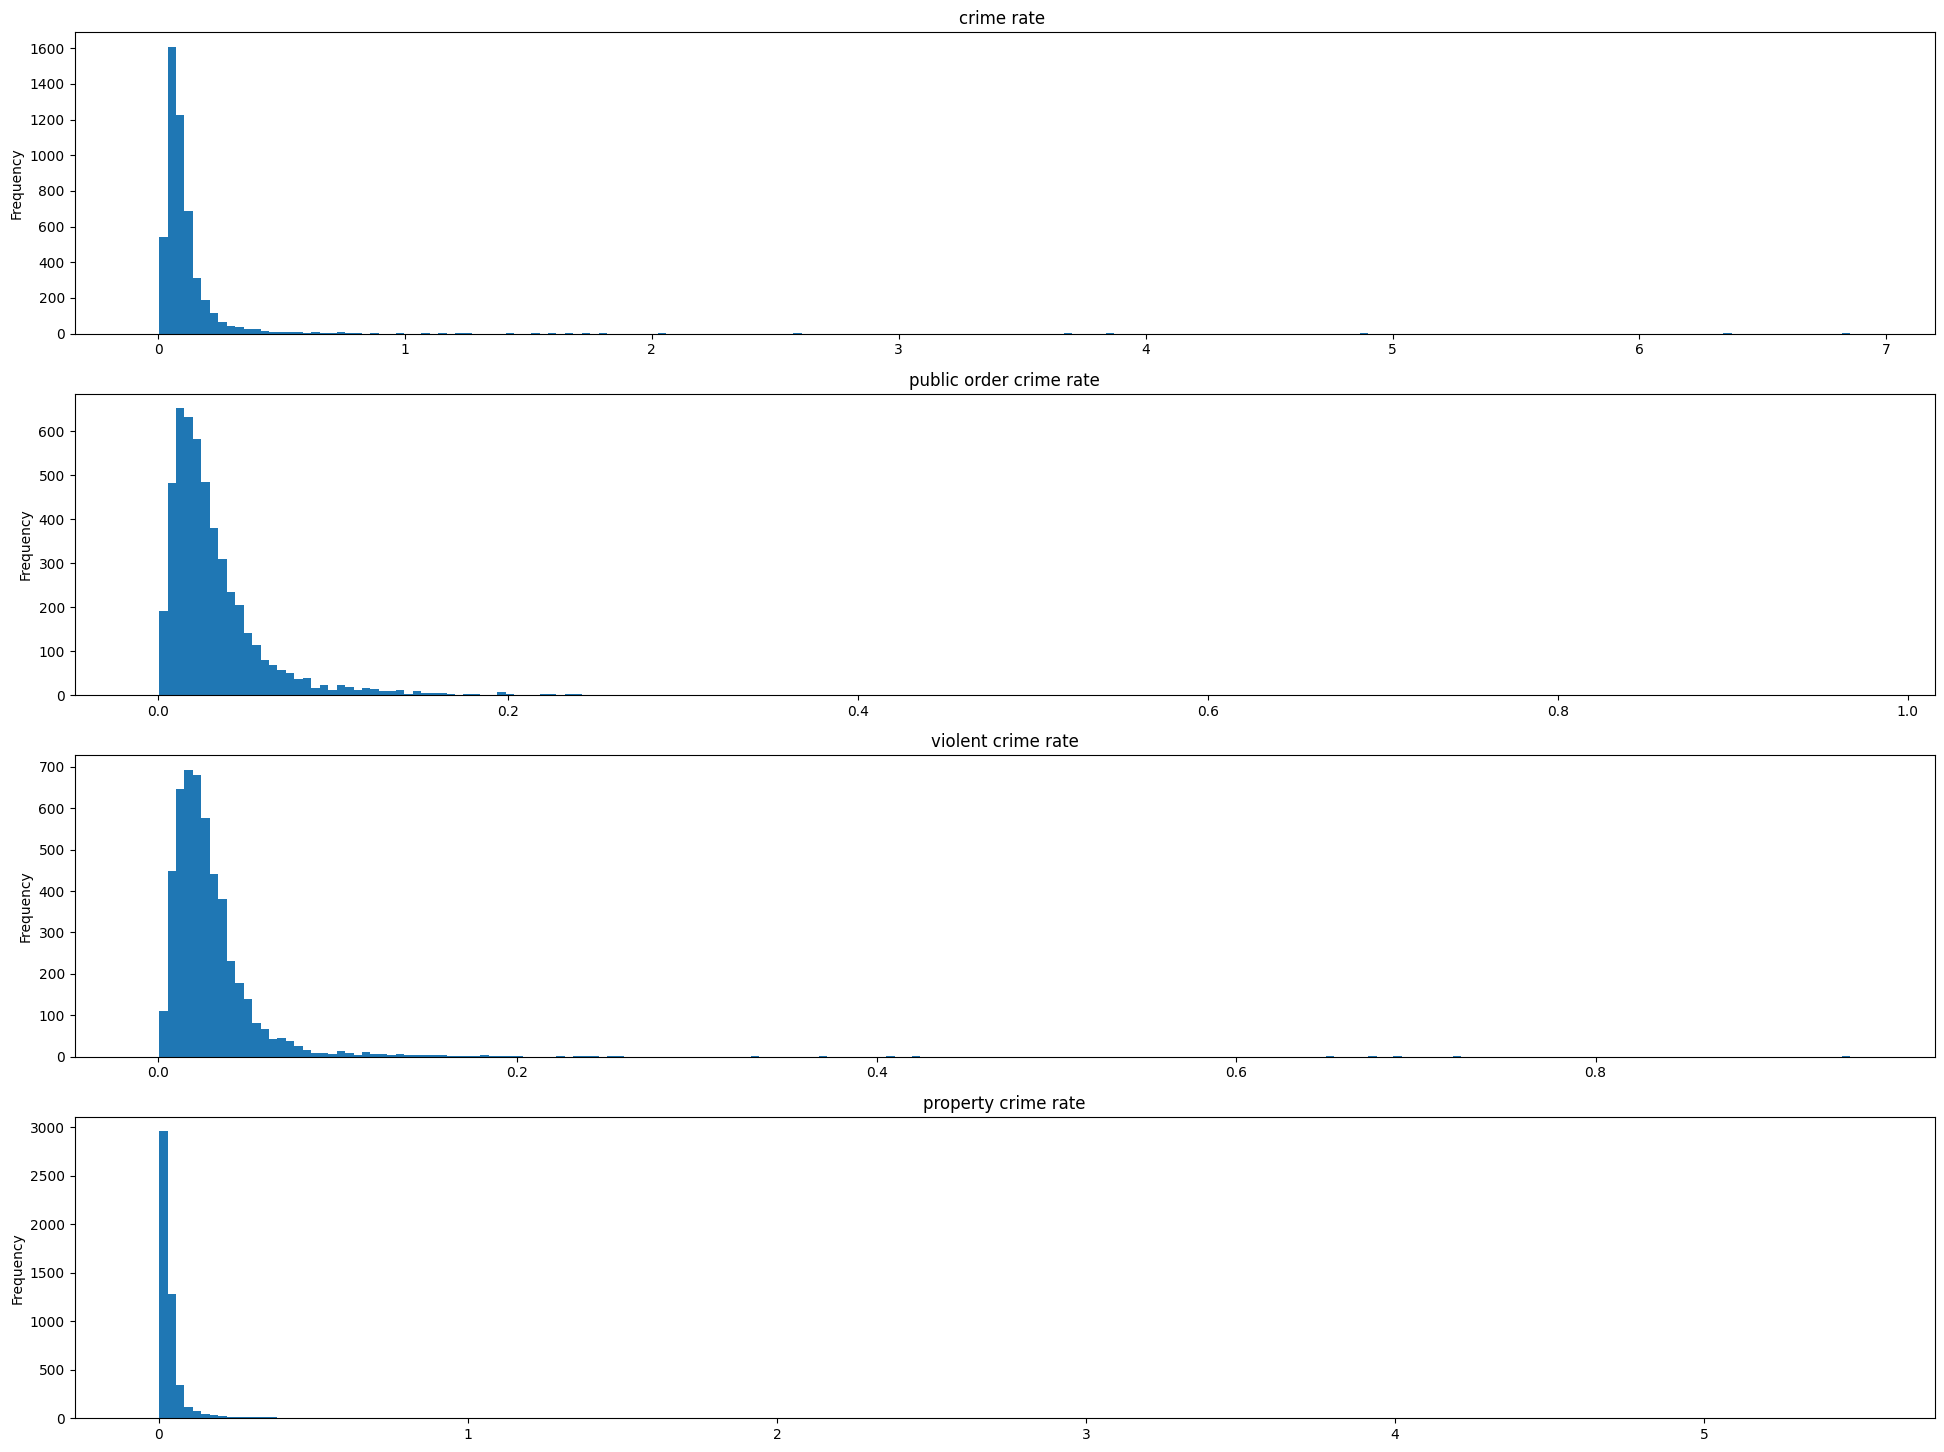

In [23]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(24,18))
lsoa_merge1.crime_rate.plot.hist(ax=ax1,bins=200)
lsoa_merge1.public_order_crime_rate.plot.hist(ax=ax2,bins=200)
lsoa_merge1.violent_crime_rate.plot.hist(ax=ax3,bins=200)
lsoa_merge1.property_crime_rate.plot.hist(ax=ax4,bins=200)
ax1.set_title('crime rate ')
ax2.set_title('public order crime rate')
ax3.set_title('violent crime rate')
ax4.set_title('property crime rate')
plt.show()

All histograms are positively skewed, meaning they have long tails to the right of the peak. This skewness indicates that the majority of observations are concentrated on the lower end of the crime rate spectrum, with a relatively small number of observations showing higher crime rates.

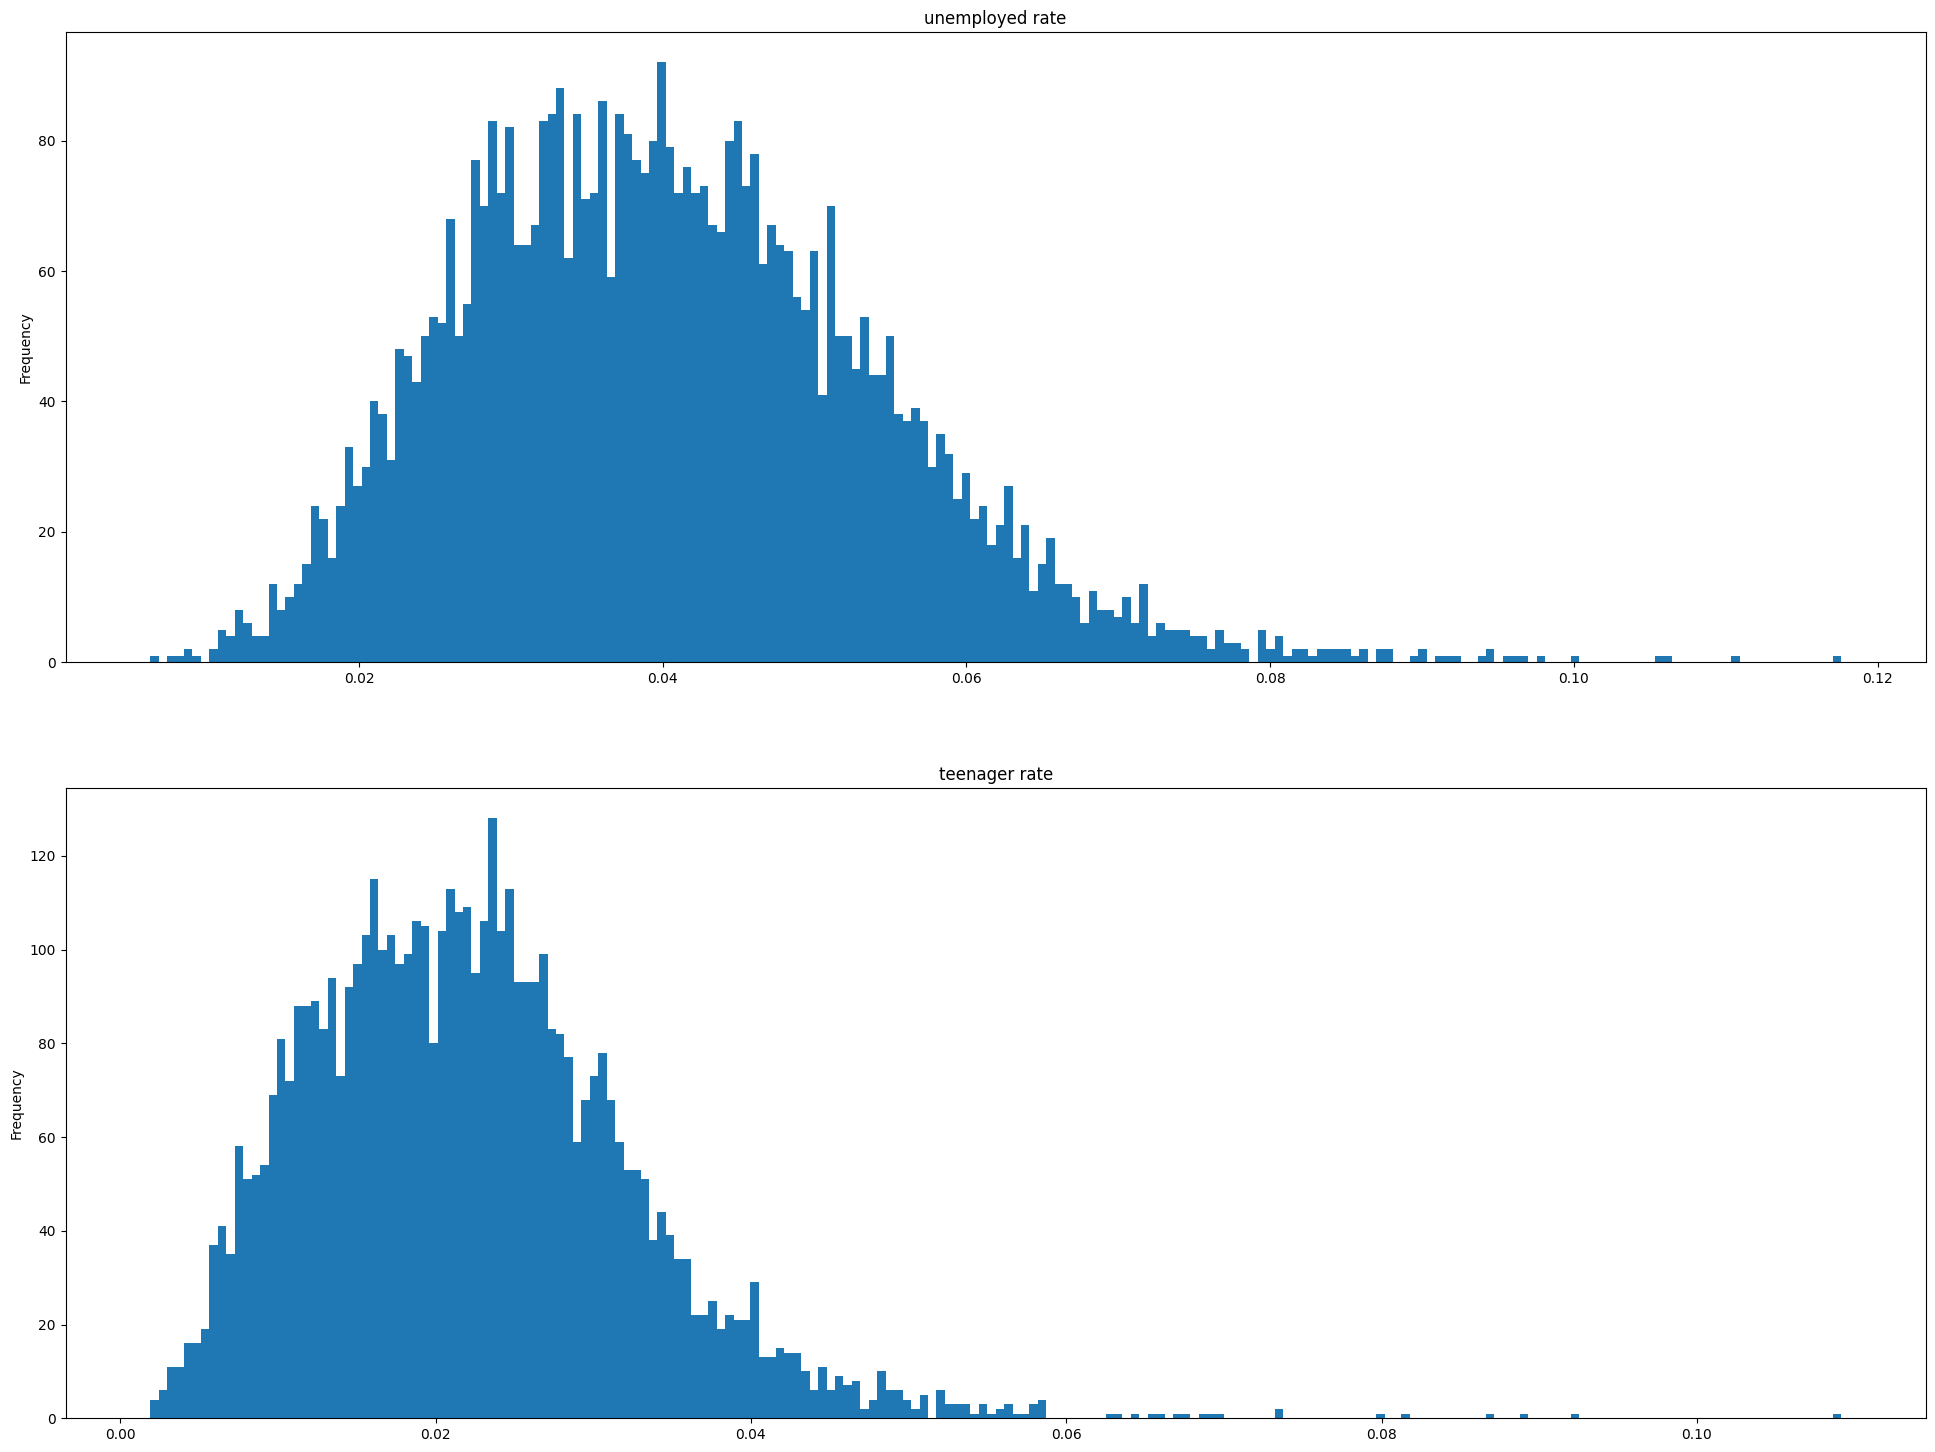

In [24]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(24,18))
lsoa_merge1.unemployed_rate.plot.hist(ax=ax1,bins=200)
lsoa_merge1.teenage_rate.plot.hist(ax=ax2,bins=200)

ax1.set_title('unemployed rate')
ax2.set_title('teenager rate')

plt.show()

Because one of the drawbacks of the k-means algorithm is its sensitivity to outliers, and given that the crime rate data is very positively skewed, outliers have a significant impact. A log transformation is an effective method to reduce data variability and achieve data normality(Changyong et al., 2014).

In [25]:
lsoa_merge1['crime_rate_log'] = np.log(lsoa_merge1['crime_rate'])
lsoa_merge1['public_order_crime_rate_log'] = np.log(lsoa_merge1['public_order_crime_rate'])
lsoa_merge1['violent_crime_rate_log'] = np.log(lsoa_merge1['violent_crime_rate'])
lsoa_merge1['property_crime_rate_log'] = np.log(lsoa_merge1['property_crime_rate'])

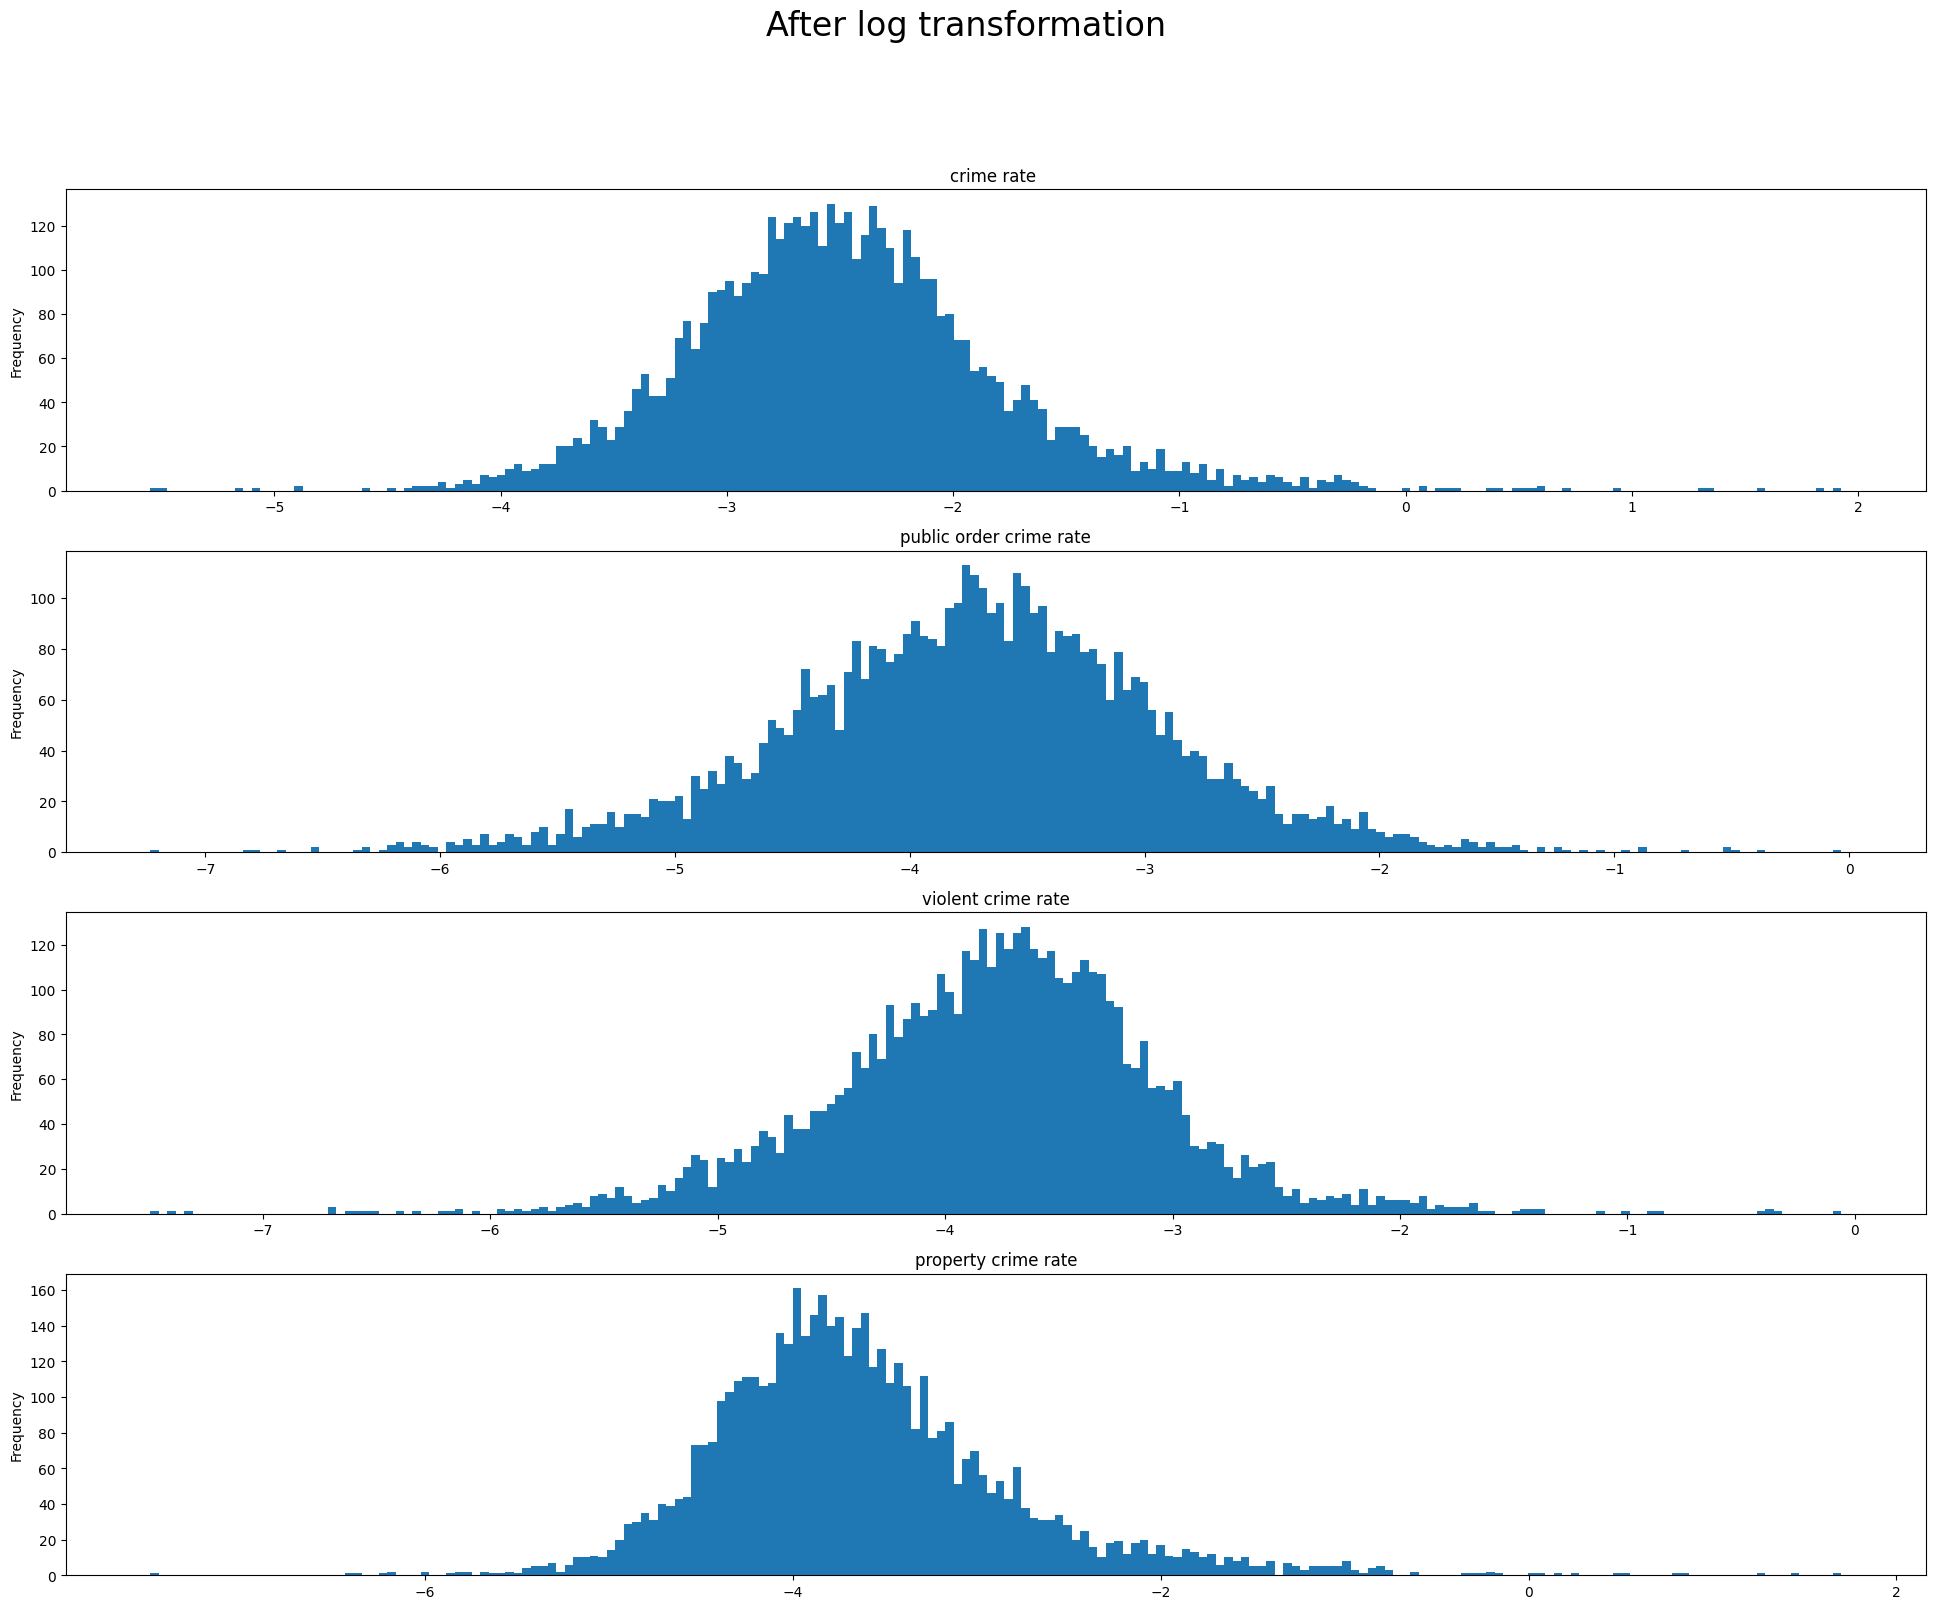

In [26]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(24,18))
fig.suptitle('After log transformation', size = 24)
lsoa_merge1.crime_rate_log.plot.hist(ax=ax1,bins=200)
lsoa_merge1.public_order_crime_rate_log.plot.hist(ax=ax2,bins=200)
lsoa_merge1.violent_crime_rate_log.plot.hist(ax=ax3,bins=200)
lsoa_merge1.property_crime_rate_log.plot.hist(ax=ax4,bins=200)
ax1.set_title('crime rate ')
ax2.set_title('public order crime rate')
ax3.set_title('violent crime rate')
ax4.set_title('property crime rate')
plt.show()

In [27]:
lsoa_merge1.dropna(axis=0, inplace=True)

The images below are distributions of crime rates.

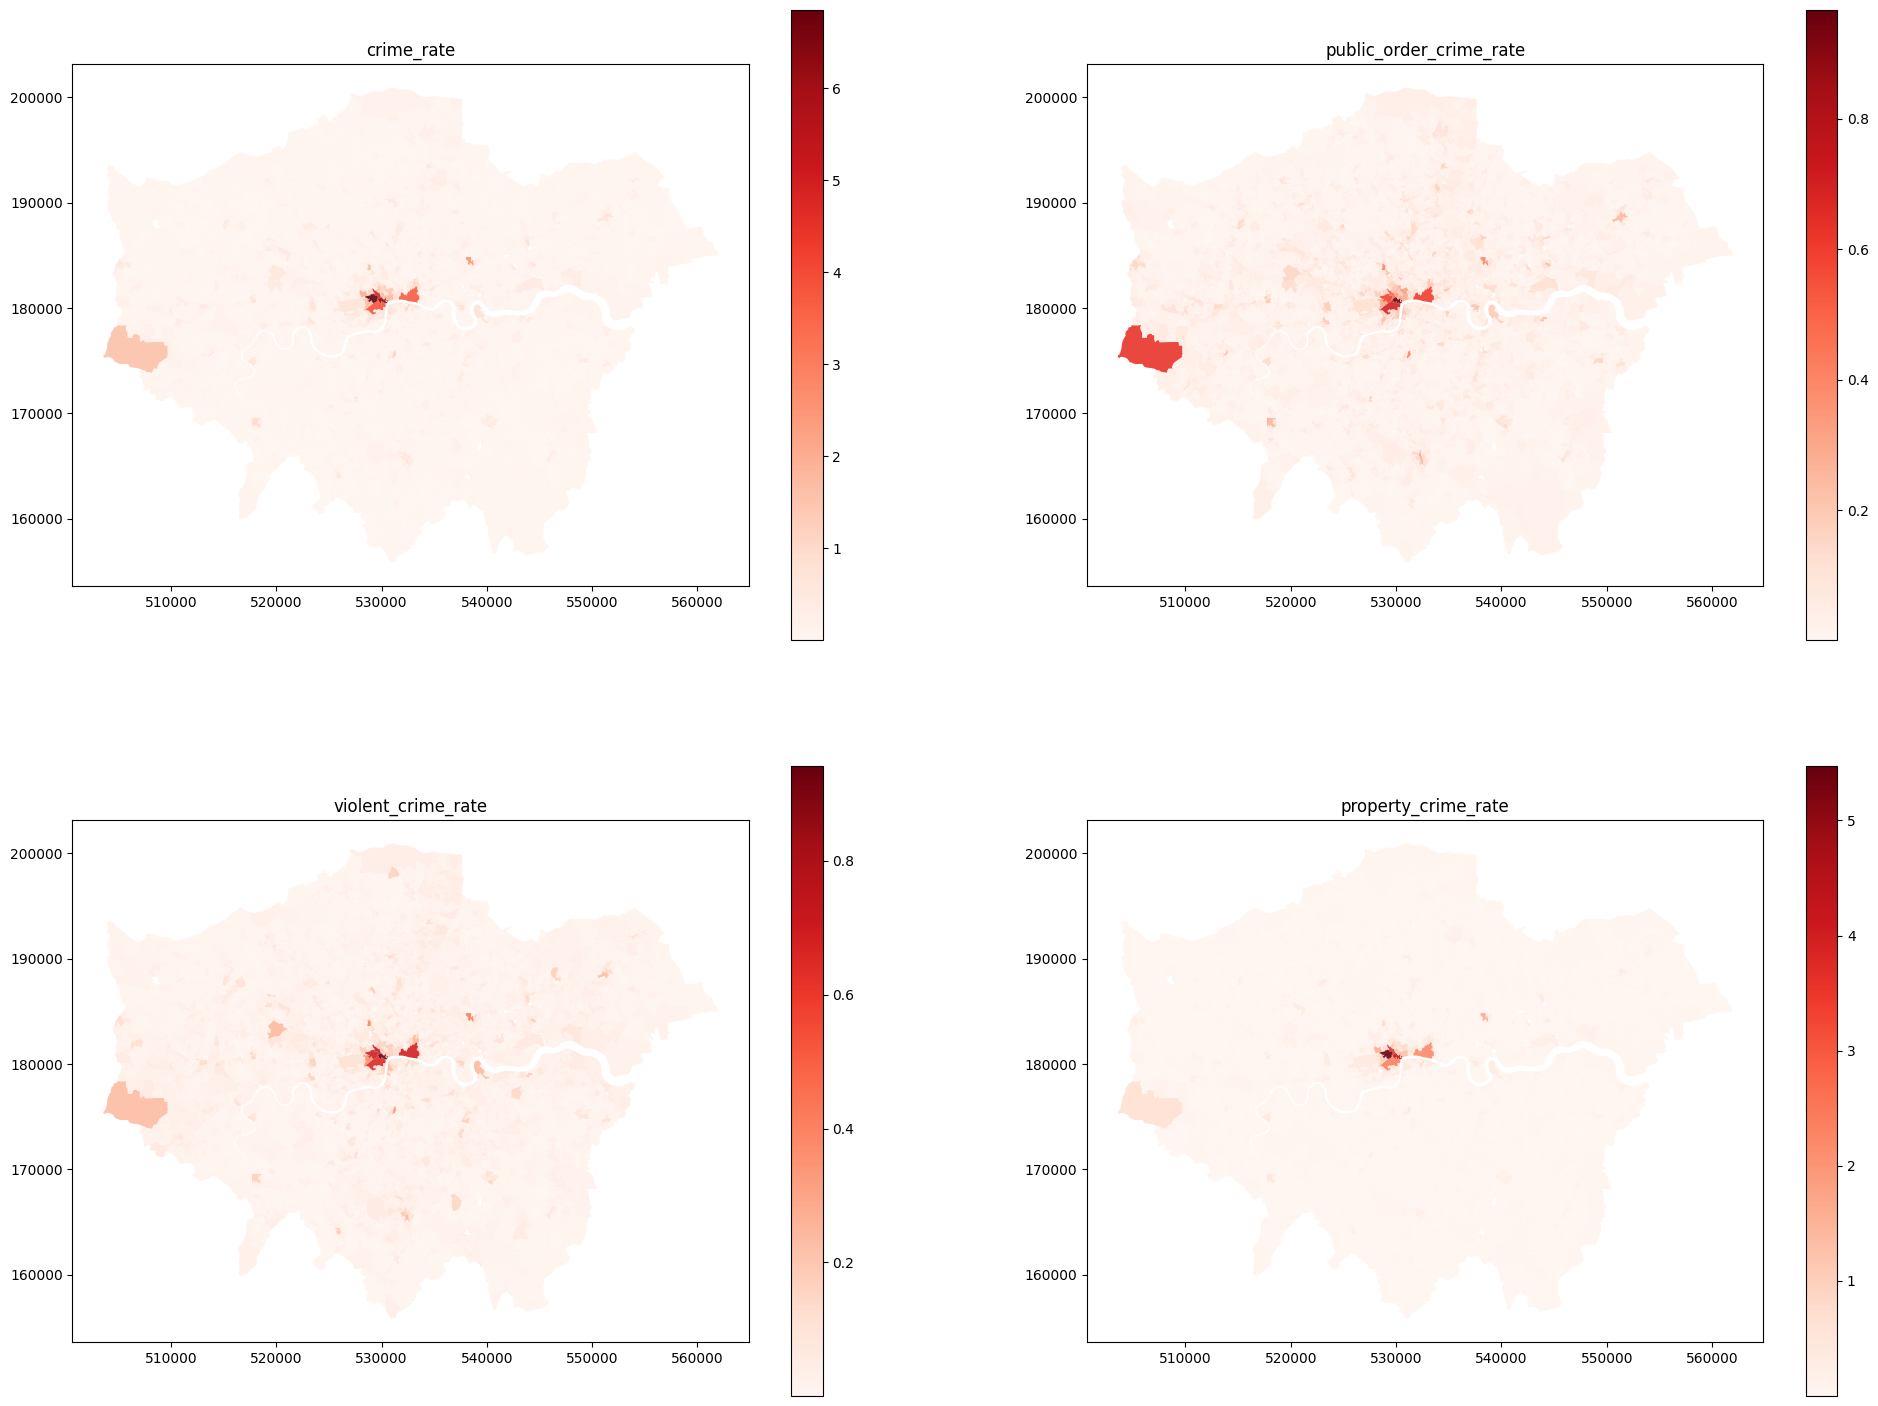

In [30]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 18))
axes = [ax1, ax2, ax3, ax4]

for i, crime_type in enumerate(['crime_rate', 'public_order_crime_rate', 'violent_crime_rate', 'property_crime_rate']):
    lsoa_merge1.plot(ax=axes[i], column=crime_type, legend=True, cmap='Reds', alpha=0.9)
    axes[i].set_title(f'{crime_type}')

plt.show()

# Clustering!

In [31]:
def mapping_clusters(labels_cluster):
    lsoa_merge1['cluster_nm'] = labels_cluster
    lsoa_merge1.plot(column='cluster_nm', categorical=True, legend=True, figsize=(12,8), cmap='Paired');

In [32]:
# adapted from this tutorial: https://towardsdatascience.com/how-to-make-stunning-radar-charts-with-python-implemented-in-matplotlib-and-plotly-91e21801d8ca
def radar_plot_cluster_centroids(df_cluster_centroid):
    # parameters
    # df_cluster_centroid: a dataframe with rows representing a cluster centroid and columns representing variables
    
    # add an additional element to both categories and restaurants that’s identical to the first item
    # manually 'close' the line
    categories = df_cluster_centroid.columns.values.tolist()
    categories = [*categories, categories[0]]
    
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(categories))
    
    plt.figure(figsize=(12, 8))
    plt.subplot(polar=True)
    for index, row in df_cluster_centroid.iterrows():
        centroid = row.tolist()
        centroid = [*centroid, centroid[0]]
        label = "Cluster {}".format(index)
        plt.plot(label_loc, centroid, label=label)
    plt.title('Cluster centroid comparison', size=20, y=1.05)
    lines, labels = plt.thetagrids(np.degrees(label_loc), labels=categories)
    plt.legend()
    plt.show()

In [33]:

rs = RobustScaler(quantile_range=(10.0, 90.0))

In [34]:

df1 = lsoa_merge1[['LSOA21CD','crime_rate_log','teenage_rate','unemployed_rate']]
df1.set_index('LSOA21CD', inplace=True)

In [35]:
df1.head()

crime_rate_log  teenage_rate  unemployed_rate
LSOA21CD                                                
E01000001       -2.284421      0.014257         0.025811
E01000002       -1.285866      0.023878         0.024596
E01000003       -2.811140      0.022319         0.045213
E01000005       -0.444938      0.041404         0.061203
E01000006       -3.006661      0.025543         0.040645

### Standardisation

We will use the ```RobustScaler``` class from the ```sklearn``` package for standardising the dataset. 

The RobustScaler is robust to outlier. It removes the median and scales the data according to the quantile range (defaults to between 25 quantile and 75 quantile, also called the Interquartile Range or IQR).

In [36]:
normed = df1.copy()
for c in df1.columns.values:
    normed[c] = rs.fit_transform(df1[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed[c].min(), normed[c].max()))
normed.head()

The range of crime_rate_log is [-1.8316381716076273, 2.693144110293424]
The range of teenage_rate is [-0.7901207284399858, 3.571072852694266]
The range of unemployed_rate is [-0.9648933603301447, 2.263373197800955]


crime_rate_log  teenage_rate  unemployed_rate
LSOA21CD                                                
E01000001        0.144478     -0.287620        -0.397777
E01000002        0.749115      0.103626        -0.432994
E01000003       -0.174457      0.040202         0.164711
E01000005        1.258308      0.816263         0.628308
E01000006       -0.292848      0.171331         0.032275

### Find the best number of clusters
The Elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters and picking the elbow of the curve as the number of clusters to use. Generally, it's the point at which the rate of decrease sharply changes.

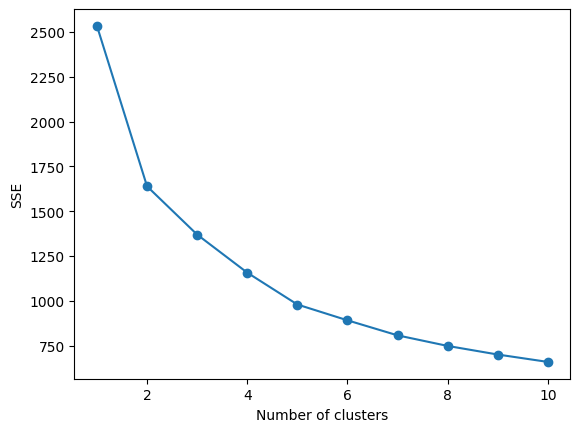

In [37]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

K = 2 is a good choice

c:\Users\17197\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


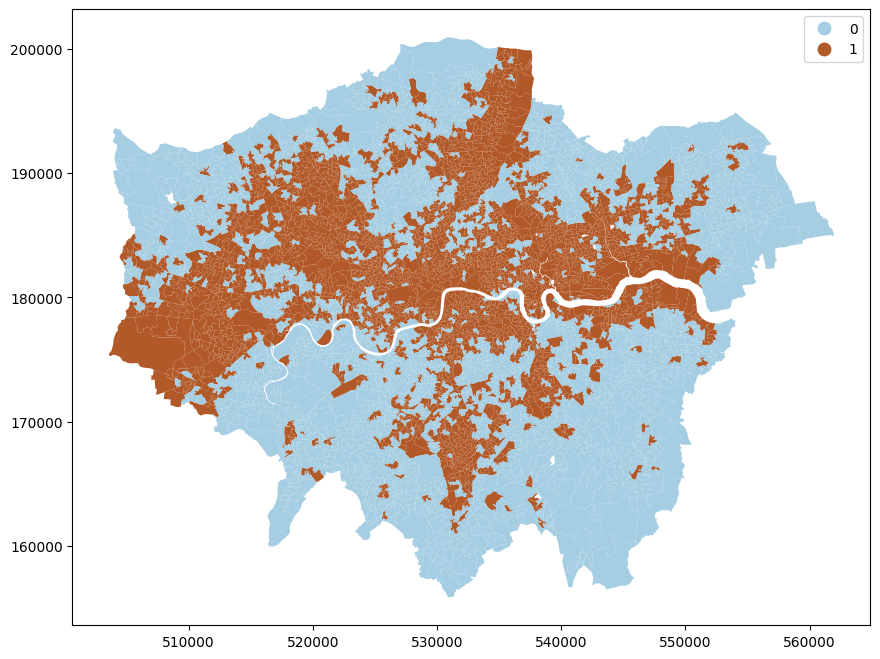

In [38]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed)
mapping_clusters(kmeans_method.labels_);

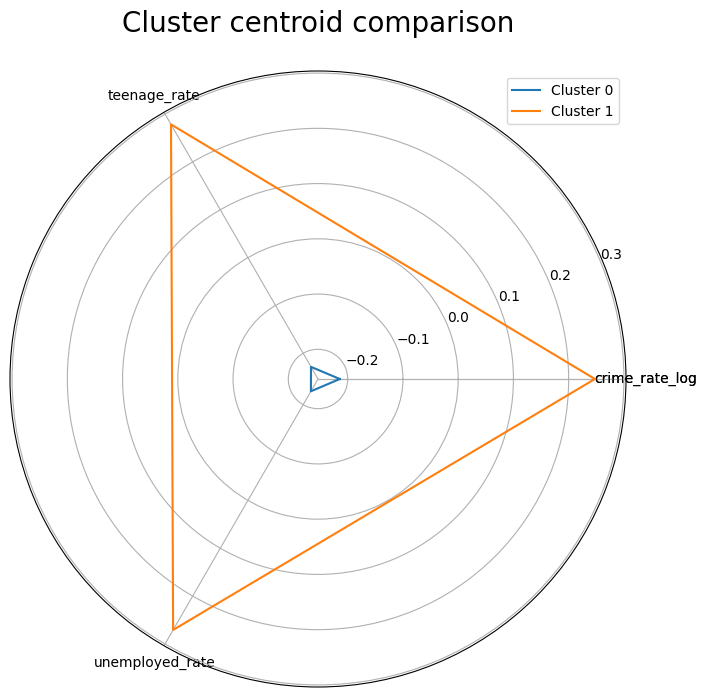

In [39]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

The only measure that can help is the Silhouette Score, which calculates how close points are on average to points their clustered with, relative to points they are not clustered with.

The `scikit-learn` algorithm ([docs](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient)) for Silhouette Score simply takes the data and the generated labels. A score closer to one indicates strong clustering, negative scores indicate poor clustering.


In [40]:
from sklearn import metrics
metrics.silhouette_score(normed, kmeans_method.labels_)

0.3182008649011523

In [41]:
df2 = lsoa_merge1[['LSOA21CD','public_order_crime_rate_log','teenage_rate','unemployed_rate']]
df2.set_index('LSOA21CD', inplace=True)

In [42]:
normed1 = df2.copy()
for c in df2.columns.values:
    normed1[c] = rs.fit_transform(df2[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed1[c].min(), normed1[c].max()))
normed1.head()

The range of public_order_crime_rate_log is [-1.792018133903522, 1.870598581376757]
The range of teenage_rate is [-0.7901207284399858, 3.571072852694266]
The range of unemployed_rate is [-0.9648933603301447, 2.263373197800955]


public_order_crime_rate_log  teenage_rate  unemployed_rate
LSOA21CD                                                             
E01000001                    -0.029281     -0.287620        -0.397777
E01000002                     0.199325      0.103626        -0.432994
E01000003                    -0.296891      0.040202         0.164711
E01000005                     0.855417      0.816263         0.628308
E01000006                    -0.241198      0.171331         0.032275

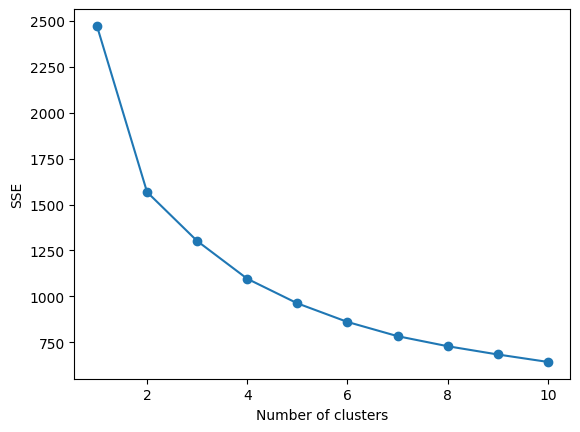

In [43]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed1)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

K = 2 is a good choice

c:\Users\17197\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


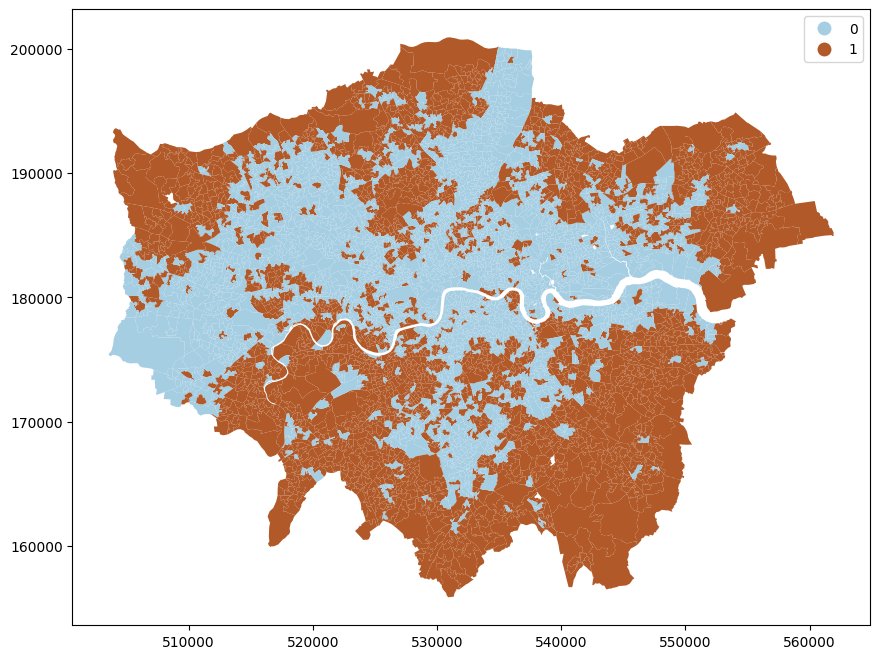

In [44]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed1)
mapping_clusters(kmeans_method.labels_);

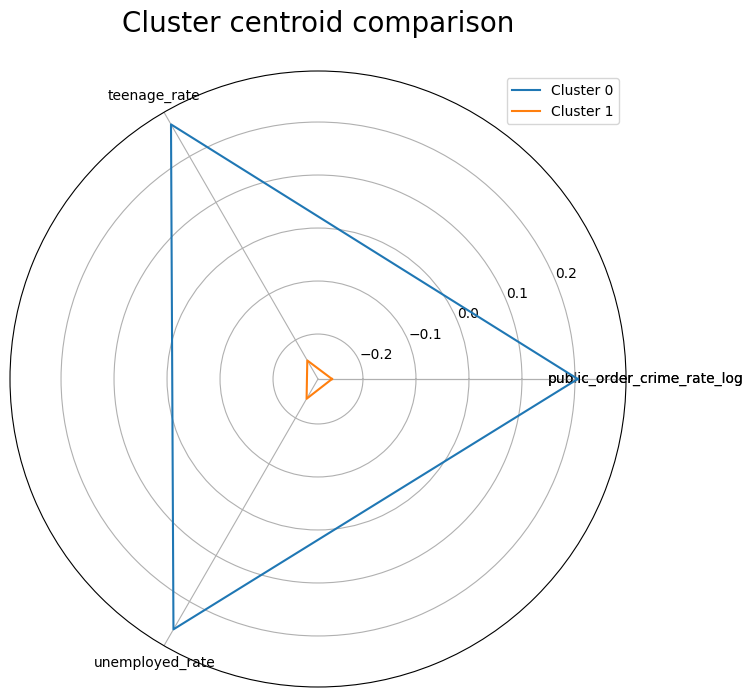

In [45]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed1.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

In [46]:
from sklearn import metrics
metrics.silhouette_score(normed1, kmeans_method.labels_)

0.32430523245049947

In [47]:
df3 = lsoa_merge1[['LSOA21CD','violent_crime_rate_log','teenage_rate','unemployed_rate']]
df3.set_index('LSOA21CD', inplace=True)

In [48]:
normed2 = df3.copy()
for c in df3.columns.values:
    normed2[c] = rs.fit_transform(df3[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed2[c].min(), normed2[c].max()))
normed2.head()

The range of violent_crime_rate_log is [-2.2163622311197204, 2.18713893742722]
The range of teenage_rate is [-0.7901207284399858, 3.571072852694266]
The range of unemployed_rate is [-0.9648933603301447, 2.263373197800955]


violent_crime_rate_log  teenage_rate  unemployed_rate
LSOA21CD                                                        
E01000001               -0.386417     -0.287620        -0.397777
E01000002                0.323687      0.103626        -0.432994
E01000003               -0.245605      0.040202         0.164711
E01000005                1.067417      0.816263         0.628308
E01000006               -0.060183      0.171331         0.032275

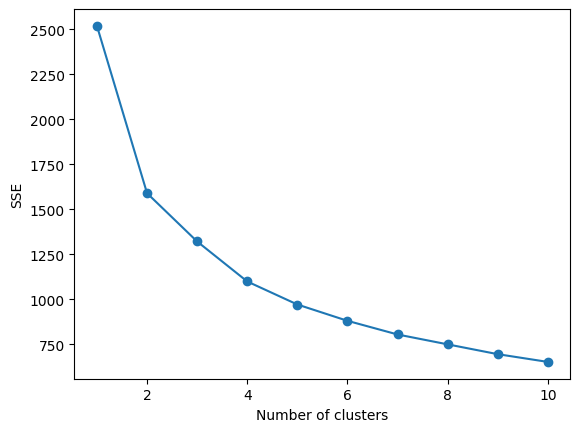

In [49]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed2)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

K = 2 is a good choice

c:\Users\17197\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


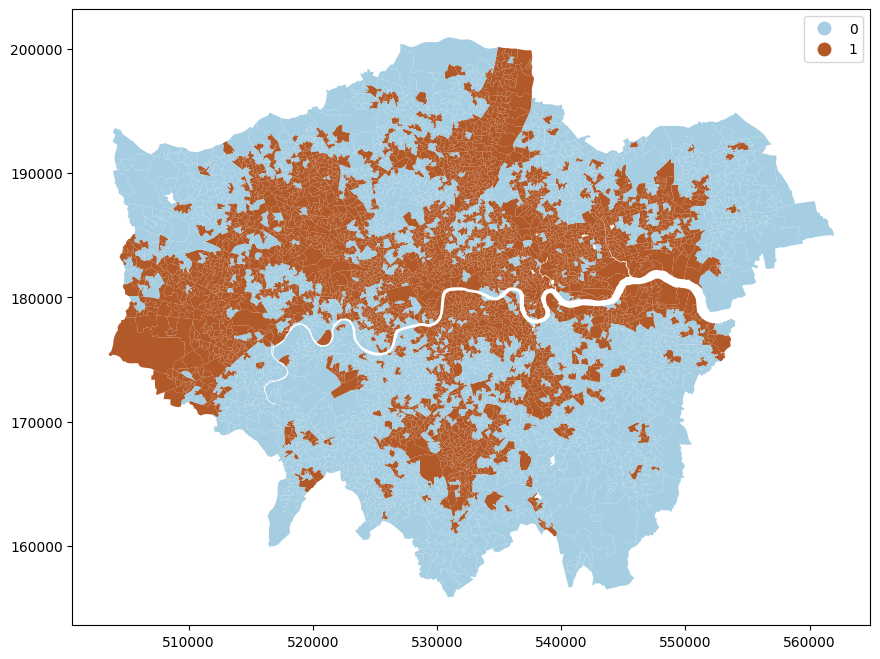

In [50]:
k_cluster = 2
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed2)
mapping_clusters(kmeans_method.labels_);

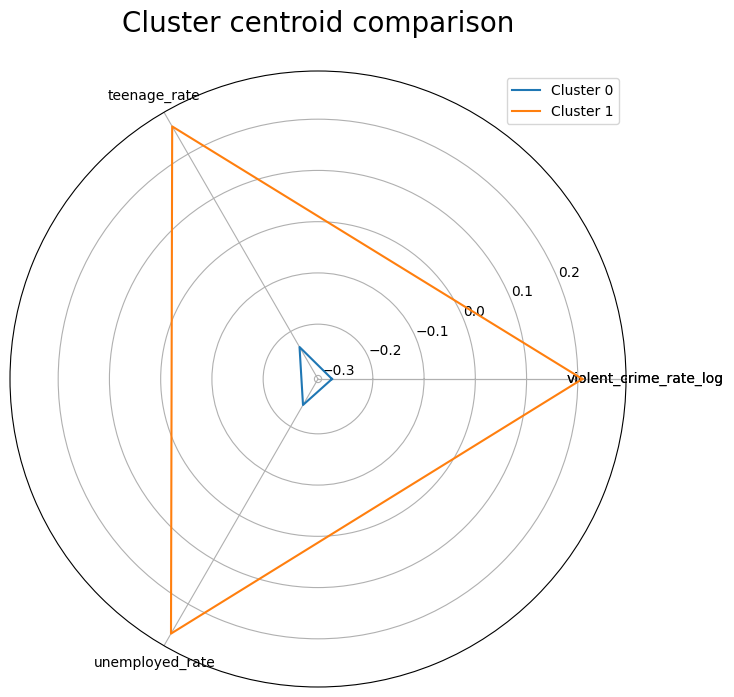

In [51]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed2.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

In [52]:
from sklearn import metrics
metrics.silhouette_score(normed2, kmeans_method.labels_)

0.3280668341764684

In [53]:
df4 = lsoa_merge1[['LSOA21CD','property_crime_rate_log','teenage_rate','unemployed_rate']]
df4.set_index('LSOA21CD', inplace=True)

In [54]:
normed3 = df4.copy()
for c in df4.columns.values:
    normed3[c] = rs.fit_transform(df4[c].values.reshape(-1,1))
    print("The range of {} is [{}, {}]".format(c, normed3[c].min(), normed3[c].max()))
normed3.head()

The range of property_crime_rate_log is [-2.0335012999130795, 2.944430182367487]
The range of teenage_rate is [-0.7901207284399858, 3.571072852694266]
The range of unemployed_rate is [-0.9648933603301447, 2.263373197800955]


property_crime_rate_log  teenage_rate  unemployed_rate
LSOA21CD                                                         
E01000001                 0.411857     -0.287620        -0.397777
E01000002                 1.076175      0.103626        -0.432994
E01000003                -0.049965      0.040202         0.164711
E01000005                 1.422847      0.816263         0.628308
E01000006                -0.481310      0.171331         0.032275

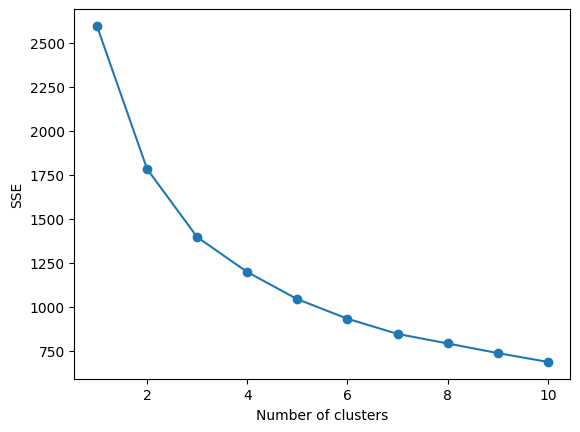

In [55]:
# calculate SSE for a range of number of cluster
list_SSE = []
min_k = 1
max_k = 10
range_k = range(min_k, max_k+1)
for i in range_k:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(normed3)
    # inertia is a concept from physics. Roughly it means SSE of clustering.
    list_SSE.append(km.inertia_)

# plot
plt.plot(range_k, list_SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

K = 3 is a good choice

c:\Users\17197\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


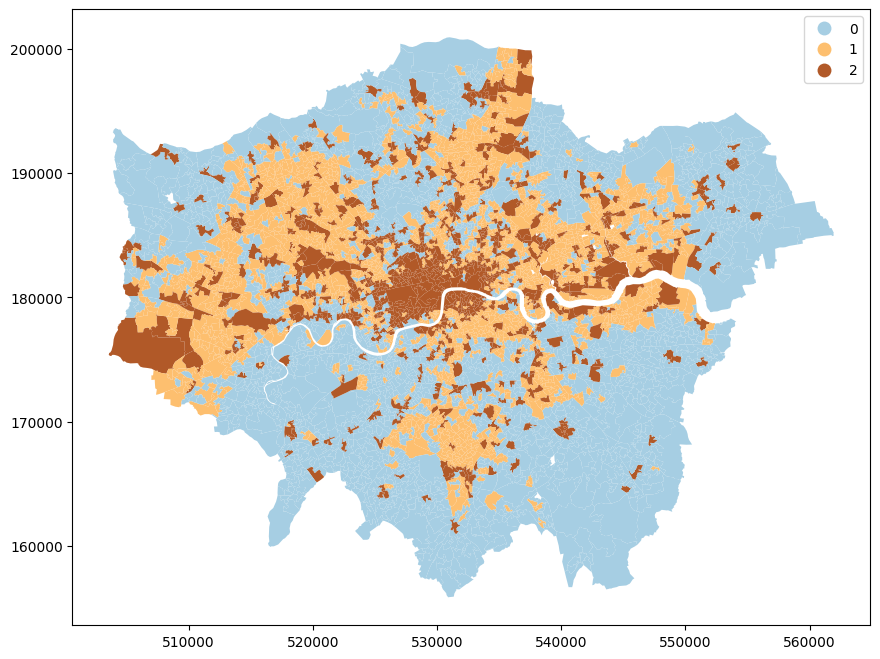

In [56]:
k_cluster = 3
random_seed = 1
kmeans_method = KMeans(n_clusters=k_cluster,random_state=random_seed)
kmeans_method.fit(normed3)
mapping_clusters(kmeans_method.labels_);

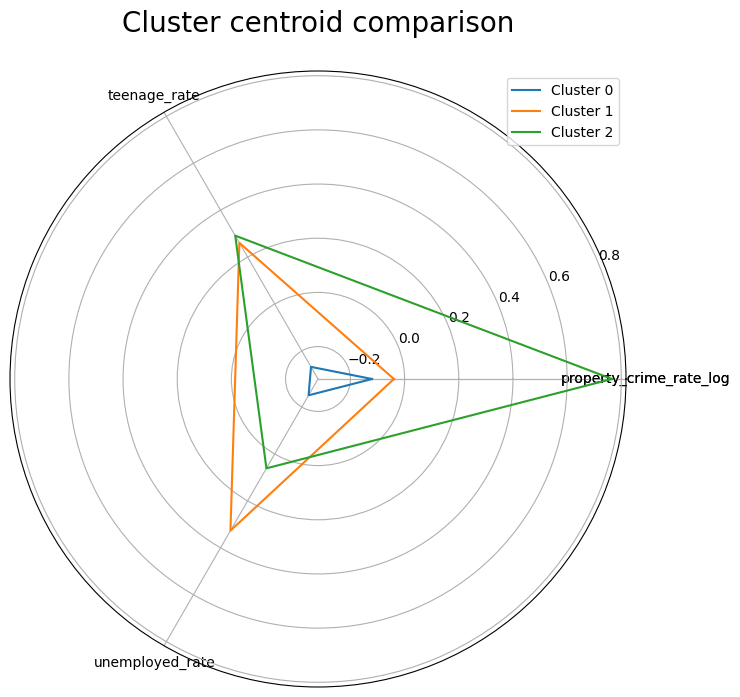

In [57]:
df_cluster_centroid = pd.DataFrame(kmeans_method.cluster_centers_, columns=normed3.columns)
radar_plot_cluster_centroids(df_cluster_centroid)

In [58]:
from sklearn import metrics
metrics.silhouette_score(normed3, kmeans_method.labels_)

0.30193016900250047

### Results

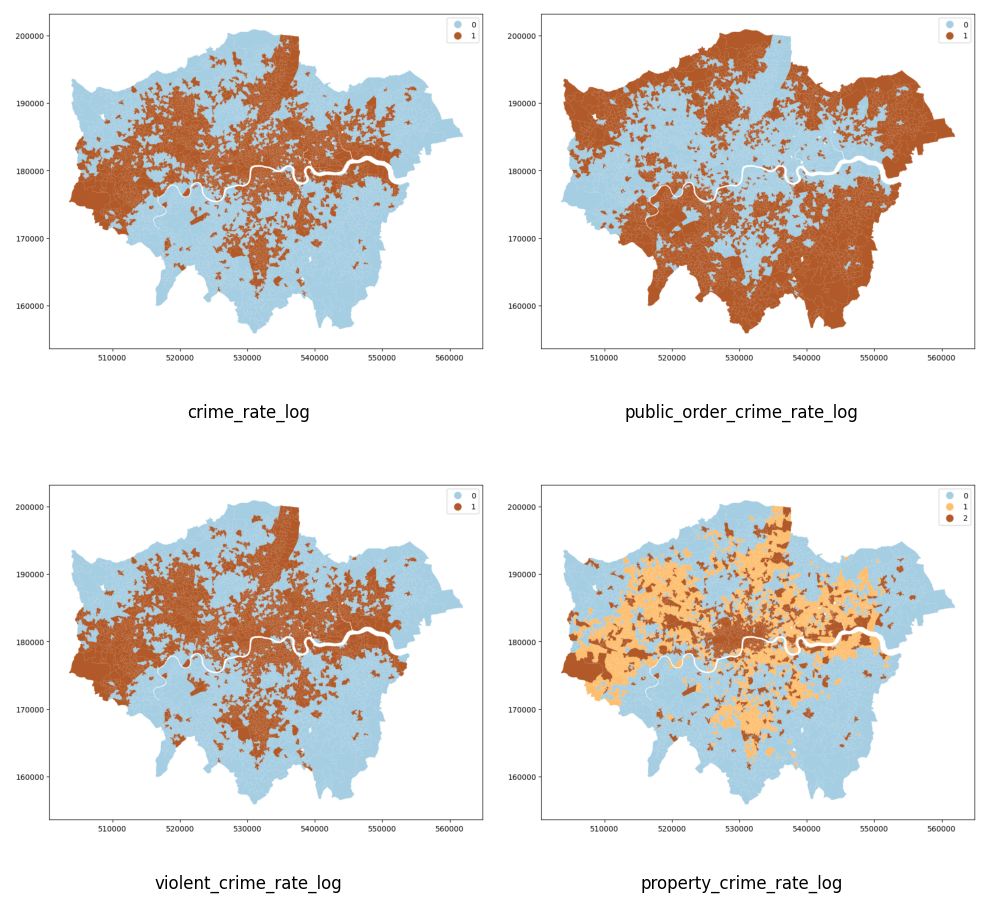

In [79]:
# Load the images
img1 = mpimg.imread('output/output1.1.png')
img2 = mpimg.imread('output/output2.1.png')
img3 = mpimg.imread('output/output3.1.png')
img4 = mpimg.imread('output/output4.1.png')

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Titles for each image
titles = ["crime_rate_log", "public_order_crime_rate_log", "violent_crime_rate_log", "property_crime_rate_log"]

# Show each image in a subplot and add a name below
for i, ax in enumerate(axs.flat):
    # Show image
    ax.imshow([img1, img2, img3, img4][i])
    ax.axis('off')  # Hide axis

    

    # Add text below the image
    ax.text(0.5, -0.1, titles[i], transform=ax.transAxes,
            ha='center', va='top', fontsize=12)

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

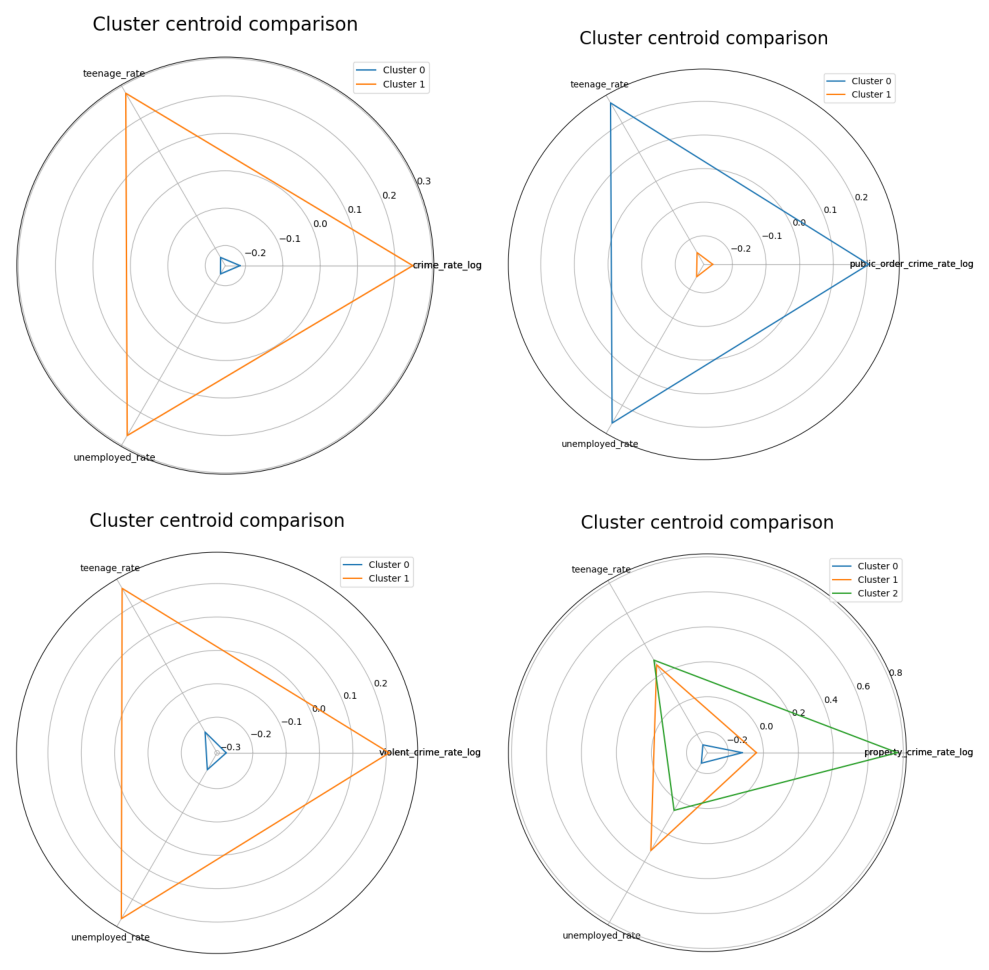

In [77]:
img1 = mpimg.imread('output/output1.2.png')
img2 = mpimg.imread('output/output2.2.png')
img3 = mpimg.imread('output/output3.2.png')
img4 = mpimg.imread('output/output4.2.png')

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Show each image in a subplot
axs[0, 0].imshow(img1)
axs[0, 0].axis('off')  # Hide axis

axs[0, 1].imshow(img2)
axs[0, 1].axis('off')

axs[1, 0].imshow(img3)
axs[1, 0].axis('off')

axs[1, 1].imshow(img4)
axs[1, 1].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()
plt.show()

# Discussion and Conclusion

Based on the spatial distribution of crime rates from the four graphs, the distribution of clusters with higher crime rates is very similar across all types. Therefore, I believe that there is no significant spatial variation in the types of crime; each LSOA does not have a clear tendency towards any particular type of crime. From the first three radar plots, it is not difficult to conclude that clusters with high crime rates also have a high proportion of youth and unemployment rates. This makes me wonder if there is a positive relationship between unemployment rates, the proportion of youth, and crime rates. Next, I will use linear regression to test this hypothesis.

In [59]:
name_list = ['LSOA21CD','crime_rate_log' ,'unemployed_rate', 'teenage_rate']
df = lsoa_merge1[name_list]
# make the correlation matrix
df_numeric = df.loc[:, 'crime_rate_log':'teenage_rate']



In [60]:

df_cormatrix = df_numeric.corr()# add a list to record the correlation coefficient values
corcoef_list1 = df_cormatrix['crime_rate_log'].tolist()


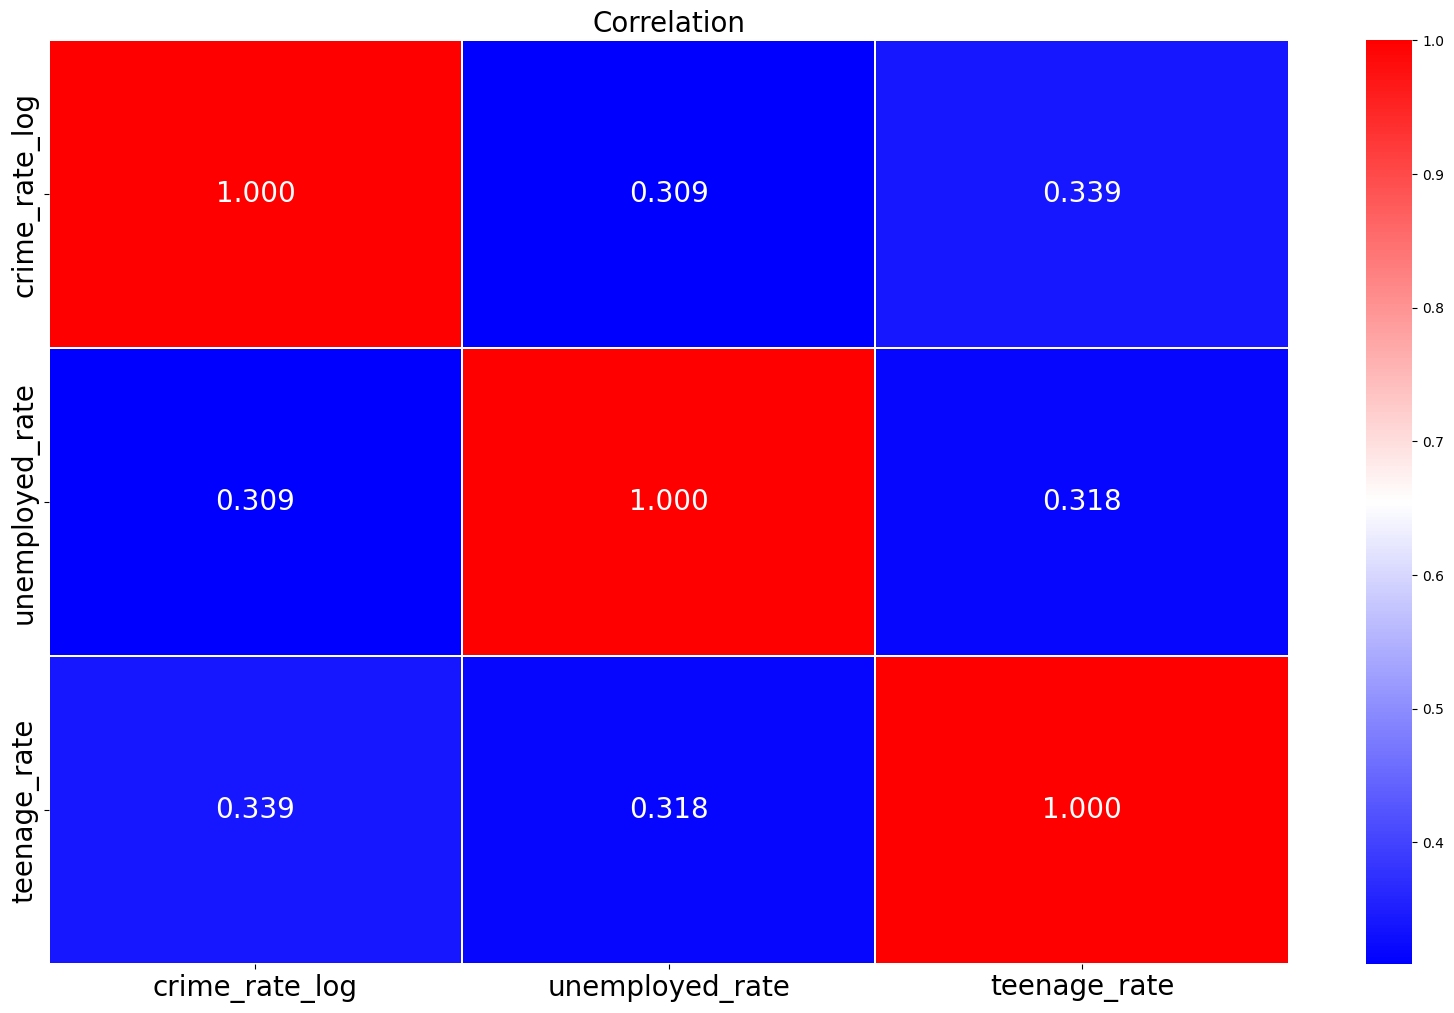

In [61]:
fig, axes = plt.subplots(figsize = (20,12))
sns.heatmap(df_cormatrix, cmap ='bwr', annot = True, fmt='.3f', linewidths = 0.1, annot_kws = {'size': 20}, ax = axes)
axes.tick_params(labelsize = 20)
axes.set_title('Correlation', fontsize = 20)
plt.show()

In [62]:
df.dropna(axis=0, inplace=True)


C:\Users\17197\AppData\Local\Temp\ipykernel_40072\3603100996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=0, inplace=True)


In [80]:
selected_features = ['unemployed_rate', 'teenage_rate']
OSLmodel1 = sm.OLS(endog=df[['crime_rate_log']], exog=sm.add_constant(df[selected_features])).fit()

test_rainbow1 = statsmodels.stats.diagnostic.linear_rainbow(OSLmodel1)
# This function returns a tuple consisting of two values: the test statistic based on the F test and the pvalue of the test
# Note that these two values are not named. Therefore, you need to know the order before accessing these two values.
print("The p value of the rainbow test: {:.4f}".format(test_rainbow1[1]))

test_dw1 = statsmodels.stats.stattools.durbin_watson(OSLmodel1.resid)
print("Durbin-Watson test statistic is: {:.4f}".format(test_dw1))
test_JB1 = statsmodels.stats.stattools.jarque_bera(OSLmodel1.resid)
print("The p value of the Jarque Bera test: {:.4f}".format(test_JB1[1]))
a= statsmodels.stats.diagnostic.het_goldfeldquandt(OSLmodel1.model.endog, OSLmodel1.model.exog)
print("The p value of the Goldfeld-Quandt homoskedasticity test: {:.4f}".format(a[1]))
OSLmodel1.summary()

The p value of the rainbow test: 0.0000
Durbin-Watson test statistic is: 1.5979
The p value of the Jarque Bera test: 0.0000
The p value of the Goldfeld-Quandt homoskedasticity test: 0.0000


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         crime_rate_log   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     472.6
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          1.20e-188
Time:                        14:12:10   Log-Likelihood:                -4832.8
No. Observations:                4979   AIC:                             9672.
Df Residuals:                    4976   BIC:                             9691.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.3477      0.031   -109.637      0.000      -3.408      -3.288
unemployed_rate    11.3141      0.693     16.321      0.000       9.955      12.673
teenage_rate       18.3107      0.938     19.513      0.000      16.471      20.150
==============================================================================
Omnibus:                      619.982   Durbin-Watson:                   1.598
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1757.552
Skew:                           0.673   Prob(JB):                         0.00
Kurtosis:                       5.581   Cond. No.                         109.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Although this is not an optimal model, based on the Rainbow Test, the model may suffer from non-linearity. From the Jarque-Bera Test, the model does not follow a normal distribution. From the Goldfeld-Quandt Test, the variance of the errors is not constant across all levels of the independent variables. However, the p-values for youth rate and unemployment rate are extremely low, and their coefficients are positive, indicating a definite positive correlation between youth rate, unemployment rate, and crime rate. 

However, when we notice the fourth radar chart, we find something strange. Although cluster 2 has a property crime rate significantly higher than that of cluster 1, the proportion of youth in both clusters is almost the same, and even the unemployment rate in cluster 2 is lower than in cluster 1. Does this contradict our previous conclusions? I believe this is due to human mobility. To explain this result, let's first go back to the data itself. The crime data records the location of the crime, which means that the criminal does not necessarily reside in the LSOA where the crime took place. Meanwhile, the attributes of an LSOA recorded include the population residing in that LSOA, so the unemployment rate describes the unemployment rate of residents within that LSOA, not the crime rate. This needs to take into account people living outside the LSOA who come to commit crimes in that LSOA, which causes some areas to have a high calculated crime rate while having a low unemployment rate.

I will use the passenger flow of the London Underground to support my point. 




In [94]:
G = nx.read_graphml('data\london1.graph')

<>:1: SyntaxWarning: invalid escape sequence '\l'
<>:1: SyntaxWarning: invalid escape sequence '\l'
C:\Users\17197\AppData\Local\Temp\ipykernel_40072\1374303717.py:1: SyntaxWarning: invalid escape sequence '\l'
  G = nx.read_graphml('data\london1.graph')


In [101]:
#since coords tuples are stored as string, need to convert them back to tuples using eval()
for node in G.nodes():
    G.nodes[node]['coords'] = eval(G.nodes[node]['coords'])

In [102]:
pos = nx.get_node_attributes(G, 'coords')


In [103]:
flows = nx.get_edge_attributes(G,'flows')

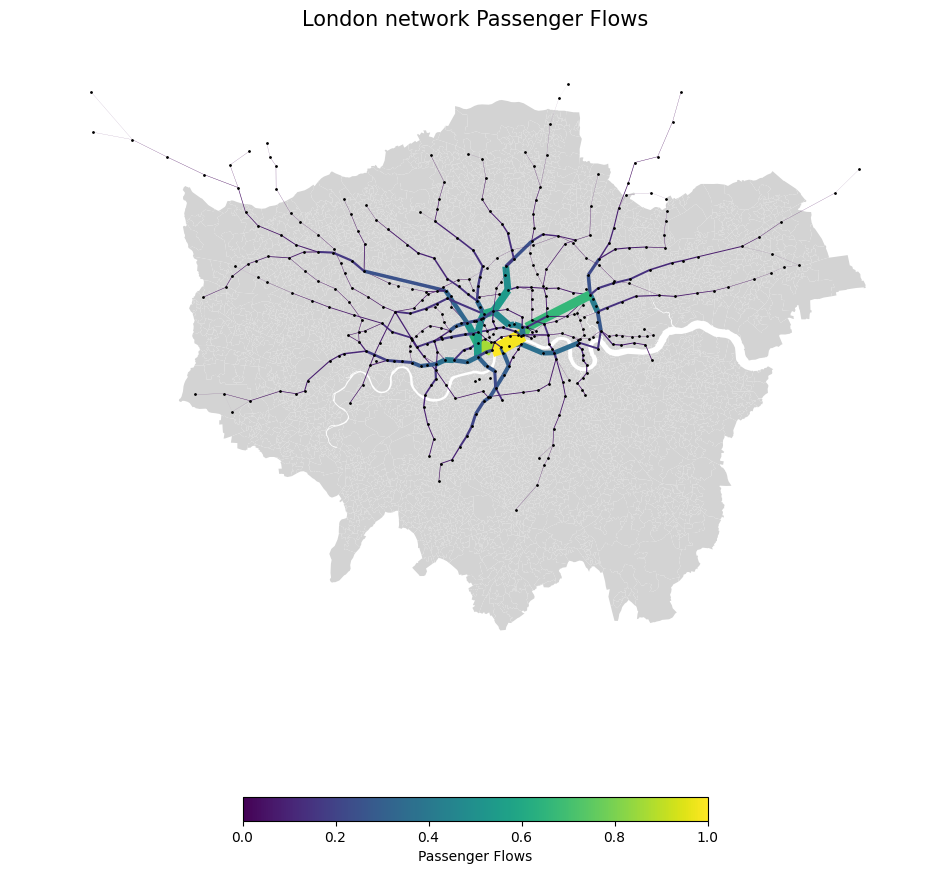

In [106]:
flows_values = flows.values()
flow_color=[(i[2]['flows']/max(flows_values)) for i in G.edges(data=True)]
flow_width=[(i[2]['flows']/max(flows_values)*10) for i in G.edges(data=True)]
# Plot graph
fig, ax = plt.subplots(figsize=(12,12))

lsoa.plot(ax=ax, color='lightgrey')
edg=nx.draw_networkx_edges(G, pos,edge_color=flow_color, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)


plt.colorbar(edg,label="Passenger Flows",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("London network Passenger Flows",fontsize=15)
plt.show()

From this chart, we can see that areas with high passenger flow overlap significantly with the location of cluster 2. Therefore, this might explain why cluster 2 has a high crime rate and a low unemployment rate, which could be attributed to the influx of people from outside the area.

Therefore, in all, to reduce the unemployment rate, my suggestion is to lower the unemployment rate, educate the youth on crime prevention, and also pay attention to the impact of human flows on the crime rate.

# Reference
K. P. Sinaga and M. -S. Yang (2020) ‘Unsupervised K-Means Clustering Algorithm’, *IEEE Access*, 8, pp. 80716–80727. Available at: https://doi.org/10.1109/ACCESS.2020.2988796.

Edmark, K. (2005) ‘Unemployment and crime: Is there a connection?’, *Scandinavian Journal of Economics*, 107(2), pp. 353–373.

Xu, Y.-H., Pennington-Gray, L. and Kim, J. (2019) ‘The Sharing Economy: A Geographically Weighted Regression Approach to Examine Crime and the Shared Lodging Sector’, *Journal of Travel Research*, 58(7), pp. 1193–1208. Available at: https://doi.org/10.1177/0047287518797197.

Ahmed, M., Seraj, R. and Islam, S.M. (2020) ‘The k-means Algorithm: A Comprehensive Survey and Performance Evaluation’, *Electronics*, 9(8). Available at: https://doi.org/10.3390/electronics9081295.

Changyong, F. et al. (2014) ‘Log-transformation and its implications for data analysis’, *Shanghai archives of psychiatry*, 26(2), p. 105.

Raphael, S. and Winter-Ebmer, R. (2001) ‘Identifying the effect of unemployment on crime’, *The journal of law and economics*, 44(1), pp. 259–283.

*Home - Office for National Statistics* (no date). Available at: https://www.ons.gov.uk/ (Accessed: 22 April 2024).

Murray, A.T. and Grubesic, T.H. (2013) ‘Exploring Spatial Patterns of Crime Using Non-hierarchical Cluster Analysis’, in M. Leitner (ed.) *Crime Modeling and Mapping Using Geospatial Technologies*. Dordrecht: Springer Netherlands, pp. 105–124. Available at: https://doi.org/10.1007/978-94-007-4997-9_5.

*Data downloads | data.police.uk* (no date). Available at: https://data.police.uk/data/ (Accessed: 22 April 2024).

Flatley, J. (2017) ‘Crime in England and Wales: year ending Sept 2016’, *Office for National Statistics-Crime Survey of England and Wales (CSEW), London* [Preprint].

Alkhaibari, A.A. and Chung, P.-T. (2017) ‘Cluster analysis for reducing city crime rates’, in. *2017 IEEE Long Island Systems, Applications and Technology Conference (LISAT)*, IEEE, pp. 1–6.

Govender, P. and Sivakumar, V. (2020) ‘Application of k-means and hierarchical clustering techniques for analysis of air pollution: A review (1980–2019)’, *Atmospheric Pollution Research*, 11(1), pp. 40–56. Available at: https://doi.org/10.1016/j.apr.2019.09.009.

Hirschi, T. and Gottfredson, M. (1983) ‘Age and the Explanation of Crime’, *American Journal of Sociology*, 89(3), pp. 552–584

Steffensmeier, D.J. et al. (1989) ‘Age and the distribution of crime’, *American journal of Sociology*, 94(4), pp. 803–831

*About | data.police.uk* (no date). Available at: https://data.police.uk/about/ (Accessed: 22 April 2024).